<a href="https://colab.research.google.com/github/Apofice2/Test-apprentissage-par-renforcement/blob/main/LunarLander_Reworked_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="./assets/Logo_ESEO_GROUPE.jpg" alt="Tech Logo" align="center" height="400" width="400"/>

<h1 align="center"; style="color:#e60000;font-size:55px">Apprentissage par renforcement</h1>

<h2 align="center"; style="color:#0099cc;font-size:30px">Aterrissez sur la lune avec un agent intelligent</h2>

Dans ce TP, le but est d'aentrainer embarqué dans un module spatial à piloter en toute sécurité l'aterrisage du module.

Nous utiliserons pour ce faire l'environnement LunarLander-v2 de Gym qui implémente un environnement lunaire, puis nous modéliserons un agent utilisant l'algorithme DQN.

<h2 style="text-align: left; color:#0099cc;font-size: 25px"><span>💾 <strong>Les règles du jeu</strong></span></h2>

La règle est assez simple : le module spatial doit atterrir à un endroit précis dans des conditions de faible gravité, et en gérant la poussée du moteur

Le but principal du jeu est donc diriger l'agent vers l'aire d'atterrissage situé entre les deux drapeaux, de la manière la plus douce et la plus économe en carburant possible.

La quantité de carburant est considérée comme infinie, donc un agent peut apprendre à voler puis atterrir à sa première tentative sans panne

<img src="./assets/lunarlander.gif" alt="Tech Logo" align="center" height="400" width="400"/>

Comme indiqué sur l'image ci-dessous, le module spatial est équipé de 3 commandes :
- accélérateur vers le bas
- accélérateur vers la gauche
- acccélérateur vers la droite

<img src="./assets/lunar.png" alt="Tech Logo" align="center" height="400" width="400"/>

Commençons à découvrir quelles sont les actions, les états et les récompenses pour cet environnement.

<h2 style="text-align: left; color:#0099cc;font-size: 25px"><span>🌎 <strong>1. Découverte de l'environnement, états, actions et récompenses</strong></span></h2>

In [ ]:
#!pip3 install Box2D

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code permettant de charger l'environnement <strong>"LunarLander-v2"</strong> de Gym </span></p>

In [ ]:
import gym
env = gym.make("LunarLander-v2").env

/home/sitou/.pyenv/versions/3.7.2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code permettant d'afficher la taille et le type de l'espace d'actions </span></p>

In [ ]:
print("Taille de l'espace d'actions : {}".format(env.action_space))

Taille de l'espace d'actions : Discrete(4)


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  Combien d'actions peut réaliser l'agent ? Quelles sont ces actions ?</span></p>

L'agent LunarLander peut effectuer 4 actions :
- 0 : ne rien faire
- 1 : accélérateur vers la gauche
- 2 : accélérateur vers le bas
- 3 : acccélérateur vers la droite

**Quid de l'espace des états ?**

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code permettant d'afficher la taille et le type de l'espace d'états </span></p>

In [ ]:
print("Taille de l'espace d'états : {}".format(env.observation_space))

Taille de l'espace d'états : Box(8,)


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  Quelle est la dimension de l'espace d'états ? A quoi correspond un état ?</span></p>

Chaque état est un vecteur de 8 variables représentant la dynamique du module spatial dans l'environnement. Notamment :
avec l'espace d'état, comme indiqué ci-dessous :

- X : Position en x du module spatial
- Y : Position en y du module spatial
- Vx : la vitesse horizontale
- Vy :  la vitesse verticale
- θ, l'orientation dans l'espace
- Vθ, la vitesse de rotation angulaire
- Tleft : booléen indiquant si le pied gauche du module solaire touche le sol
- Tright : booléen indiquant si le pied droit du module solaire touche le sol


L'aire d'aterrissage se trouve aux coordonnées (0, 0) de l'environnement

**Quid des récompenses ?**

- La récompense pour un déplacement du haut de l'écran vers l'aire d'atterrissage sans accélération est d'environ 100 à 140 points.
- Si l'atterrisseur s'éloigne de l'aire d'atterrissage, il perd sa récompense.
- L'épisode se termine si le module spatial s'écrase ou s'immobilise, avec une récompense de -100 points (le module s'écrase) ou +100 points (le module s'immobilise à l'aterissage).
- Chaque contact au sol d'un pied du module donne lieu à +10 points de récompense.
- Chaque usage de l'accélérateur donne à une récompense de -0,3 pts.
- Le PDM est résolu si l'agent atteint 200 points

<h2 style="text-align: left; color:#0099cc;font-size: 25px"><span>🤖 <strong>2. Conception de l'agent Deep Q-Network </strong></span></h2>

Le concept principal de DQN est représenté sur la figure ci-dessous (pendant le processus d'entrainement), où le réseau de neurones Q procède comme une approximation non linéaire qui faire correspondre un état à une valeur d'action.

<img src="./assets/dqn.png" alt="Tech Logo" align="center" height="600" width="800"/>

Comme tout réseau de neurones, Q-network possède une fonction de perte.

<img src="./assets/loss.png" alt="Tech Logo" align="center" height="500" width="500"/>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  Deux concepts essentiels permettent à DQN de se rapprocher du principe d'apprentissage en apprentissage supervisé. Lesquels ?</span></p>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  Quel est l'utilité de chacun de ces deux concepts ?</span></p>

Deux concepts essentiels font le succès de l'algorithme de deep Q-Learning

<p style="text-align: left; color:#0099cc;font-size: 20px"><span><strong>Utilisation d'un "target network" </strong></span></p>

Au cours du processus d'apprentissage, nous utilisons deux réseaux de neurones distincts
- "Local" Q-network
- "Target" Q-network

Le réseau "target" est gelé pendant plusieurs pas de temps, puis les poids du réseau "target" sont mis à jour en copiant les poids du réseau "local". Geler le réseau "target" pendant un certain temps, puis mettre à jour ses poids avec les poids réels du réseau "local" stabilise la formation

<p style="text-align: left; color:#0099cc;font-size: 20px"><span><strong>Utilisation d'un buffer d'expériences </strong></span></p>

Afin de rendre le processus d'entrainement plus stable (il faut éviter d'apprendre le réseau sur des données fortement corrélées, ce qui peut arriver si nous effectuons un apprentissage sur des transitions consécutives), Deep Q-Network utilise un buffer qui mémorise les expériences du comportement de l'agent.

Ensuite, l'entrainement est effectué sur des échantillons aléatoires du buffer de relecture (cela réduit la corrélation entre les transitions de l'agent et aide l'agent à mieux apprendre à partir d'un large éventail d'expériences)

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  Chacune des propositions ci-dessous entre dans le processus d'apprenitssage d'un DQN. Remettez ces propositions dans l'ordre permettant de réaliser le processus d'apprentissage</span></p>

- Après chaque k étapes, copiez nos poids de réseau "local" dans les poids du réseau "target".
- Effectuer une descente de gradient par rapport aux paramètres du réseau "local" afin de minimiser cette perte
- Instancier les réseaux de neurones DQN qui serviront pendant pendant l'entrainement
- Après avoir sélectionné l'action A, l'agent effectue l'action choisie dans un état S et passe à un nouvel état S' et reçoit une récompense R
- Enregistrer la transition dans le buffer de relecture sous la forme <S,A,R,S’>
- Initialiser le buffer de relecture
- Répétez ces étapes pendant M épisodes
- Echantillonnez quelques lots aléatoires de transitions à partir du tampon de relecture et calculez la perte à l'aide de la formule de loss ci-dessous
- Sélectionner une action en utilisant la politique epsilon-greedy : avec la probabilité epsilon, on sélectionne une action aléatoire A et avec la probabilité 1-epsilon, on sélectionne une action qui a la valeur Q maximale, telle que A = argmax(Q(S, A, θ))

L'algorithme DQN peut être décrit comme suit :

1. Initialiser le buffer de relecture,

2. Instancier les réseaux de neurones DQN qui serviront pendant pendant l'entrainement.

3. Sélectionner une action en utilisant la politique epsilon-greedy : avec la probabilité epsilon, on sélectionne une action aléatoire A et avec la probabilité 1-epsilon, on sélectionne une action qui a la valeur Q maximale, telle que A = argmax(Q(S, A, θ)).

4. Après avoir sélectionné l'action A, l'agent effectue l'action choisie dans un état S et passe à un nouvel état S' et reçoit une récompense R.

5. Enregistrer la transition dans le buffer de relecture sous la forme <S,A,R,S’>.

6. Echantillonnez quelques lots aléatoires de transitions à partir du tampon de relecture et calculez la perte à l'aide de la formule de loss ci-dessus


7. Effectuer une descente de gradient par rapport aux paramètres du réseau "local" afin de minimiser cette perte.

8. Après chaque k étapes, copiez nos poids de réseau "local" dans les poids du réseau "target".

9. Répétez ces étapes pendant M épisodes.

<h4 style="text-align: left; color:#0099cc;font-size: 25px"><span>🤖 <strong>2.1. Codage des méthodes de l'agent DQN </strong></span></h4>

Afin de pouvoir réaliser tout le processus d'entrainement ci-dessous, nous allons maintenant développer un agent DQN avec ses différentes méthodes.

In [ ]:
import random
import time
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
import progressbar
from texttable import Texttable
from IPython.display import clear_output
import tensorflow as tf
tf_config=tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=tf_config)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

2022-09-21 18:40:33.695903: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sitou/.pyenv/versions/3.7.2/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64:/usr/local/cuda-10.0/lib64:
2022-09-21 18:40:33.695921: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-21 18:40:34.685922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 18:40:34.690397: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 25999

Pour initialiser/modifier les attributs et pour coder les méthodes de l'agent DQN, travaillez sur la classe DQNAgent ci-dessous. Référez-vous directement aux docstrings de la classe pour comprendre l'utilité de chaque attribut et méthodes de la classe

<h4 style="text-align: left; color:#0099cc;font-size: 20px"><span>🤖 <strong>2.1.1. Initialisation du buffer de relecture </strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code permettant d'instancier dans la fonction d'initialisation de la classe DQNAgent un objet deque d'une profondeur maximale de 5000 éléments </span></p>

<h4 style="text-align: left; color:#0099cc;font-size: 20px"><span>🤖 <strong>2.1.2. Instanciation des réseaux de neurones DQN </strong></span></h4>

Le principe de Deep Q-Network est d'utiliser un réseau de neurones prenant en entrée l'état de l'environnement et prédisant en sortie les valeurs des actions possibles.

<img src="./assets/dqn_nn.png" alt="Tech Logo" align="center" height="400" width="400"/>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  En apprentissage supervisé, à quelle famille d'algorithmes appartiennent ces réseaux de neurones ?</span></p>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓  Sachant qu'ici les états en entrée du réseau de neurones sont des images, quelle famille de réseaux de neurones serait la plus appropriée ?</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>build_model()</strong> permettant de créer et de compiler un réseau de neurones ayant l'architecture suivante :
    <ul style="text-align: left; font-size: 16px; color:#0f767a">
            <li>Couche dense : 128 neurones de sortie, activation "relu"</li>
            <li>Couche dense : 128 neurones de sortie, activation "relu"</li>
            <li>Couche dense : x neurones de sortie, activation "linear"</li>
        </ul>
     </span></p>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Quelles sont les fonctions d'activation possibles sur la dernière couche d'un réseau de neurones ?</span></p>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Quelle est la différence entre une fonction d'activation "linear" et une fonction d'activation "softmax" ?</span></p>

<img src="./assets/linear_activation.png" alt="Tech Logo" align="center" height="400" width="400"/>

<img src="./assets/softmax.jpeg" alt="Tech Logo" align="center" height="400" width="400"/>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Pourquoi cette fonction est-elle plus indiquée dans ce cas ? ?</span></p>

Les fonctions d'activation comme softmax ou sigmoid ne sont utiles que pour ramener la sortie du réseau dans une certaine plage de données ou avec des propriétés les rendant plus facile d'utilisation. Par exemple, softmax ramène les valeurs de sortie entre 0 et 1 avec les sommes des valeurs égales 0, ce qui peut être utile dans le cas d'une classification. Dans le cas d'une regression, ce n'est pas utile !

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Connaissant la famille d'algorithme à laquelle appartient le réseau de neurones, quelle type de fonction de perte serait adéquat ?</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code permettant d'instancier dans la fonction d'initialisation de la classe DQNAgent, le réseau de neurones "local" et le réseau de neurones "target" à partir de la méthode <strong>_build_model()</strong>, puis de transférer les poids du réseau "local" vers le réseau "target". <strong>TIP : </strong> Utiliser la fonction <strong>set_weights()</strong> de Keras </span></p>

<h4 style="text-align: left; color:#0099cc;font-size: 20px"><span>🤖 <strong>2.1.3. Sélection d'une action avec une politique epsilon-greedy </strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>choose_action()</strong> permettant de choisir une action soit aléatoire soit gloutonne selon une politique epsilon-greedy. Référez-vous aux docstrings de la méthode pour davantage d'explications </span></p>

<h4 style="text-align: left; color:#0099cc;font-size: 20px"><span>🤖 <strong>2.1.4. Enregistrement des transitions dans le buffer de relecture </strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Dans la conception d'un agent DQN, à quoi sert le buffer d'expériences ?</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>store_transition()</strong> permettant d'enregistrer une transition dans le buffer d'expérience initialisé dans la fonction d'initialisation. Référez-vous aux docstrings de la méthode pour davantage d'explications  </span></p>

<h4 style="text-align: left; color:#0099cc;font-size: 20px"><span>🤖 <strong>2.1.5. Echantillonnage des transitions et entrainement par descente de gradient  </strong></span></h4>


Dans cette partie, la premère étape consiste à écrire une fonction à même d'échantillonner les données de transition dans le buffer de relecture.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>sample_batches_from_buffer()</strong> permettant d'échantillonner une liste de valeurs dans le buffer de relecture. Chaque liste de valeur contient 'batch_size' éléments
     </span><p style="text-align: left; font-size: 16px; color:#0f767a">Référez-vous aux docstrings de la méthode pour davantage d'explications </p>
</p>

La seconde étape consiste à calculer les targets, c'est-à-dire les valeurs cibles de Q-value qui vont servir à entrainer le réseau de neurones de l'agent.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>compute_targets()</strong> permettant pour chaque jeu de valeurs des listes de valeur échantillonnées précédement fournit la valeur cible correspondante. Cette fonction fournit en sortie un vecteur de target contenant 'batch_size' valeurs cibles. Le processus pour chaque jeu de transition est le suivant :
     <ul style="text-align: left; font-size: 16px; color:#0f767a">
            <li>Calculer la target c'est-à-dire la valeur cible de la Q-value pour l'action enregistrée dans la transition</li>
            <li>Calculer le vecteur de target prédit par le DQN</li>
            <li>Remplacer dans le vecteur target la valeur cible calculée selon l'approximation Q-Learning pour l'action enregistrée dans la transition</li></ul>
     </span><p style="text-align: left; font-size: 16px; color:#0f767a">Référez-vous aux docstrings de la méthode pour davantage d'explications </p>
</p>

Enfin, dernière étape : se baser sur les deux fonctions précédentes pour dérouler le processus d'entrainement du réseau de neurones de "policy" de l'agent.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>train_on_batch()</strong> permettant  d'appliquer le processus suivant
    <ul style="text-align: left; font-size: 16px; color:#0f767a">
            <li>Collecter des listes de valeurs de transition à partir du replay_buffer (states_list, actions_list, rewards_list, next_states_list, dones_list)</li>
            <li>A partir de ces listes de valeur, calculer le vecteur de target (valeur cible de Q-value)</li>
            <li>Lancer un entrainement par rétropropagation du gradient</li>
        </ul>
     </span><p style="text-align: left; font-size: 16px; color:#0f767a">Référez-vous aux docstrings de la méthode pour davantage d'explications </p>
</p>

<h4 style="text-align: left; color:#0099cc;font-size: 20px"><span>🤖 <strong>2.1.6. Mise à jour des poids du réseau target </strong></span></h4>

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Dans la conception d'un agent DQN, à quoi sert le target model ?</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code de la méthode <strong>update_target_model()</strong> de mettre à jour les poids du réseau target à partir deux du réseau local </span></p>

In [ ]:
class DQNAgent:

    """
    Classe de l'agent DQN implémentant l'algorithme Deep Q-Network
    """

    def __init__(self, state_size, action_size):

        # L'attribut state_size représente la dimension de l'espace d'états,
        # c'est-à-dire les dimensions de l'image de l'environnement de jeu
        self.state_size = state_size

        # L'attribut action_size représente la dimension de l'espace d'actions
        self.action_size = action_size

        # L'attribut render représente l'autorisation d'afficher le jeu pendant l'entrainement
        self.render = True

        # Hyperparametres

        # L'attribut gamma représente le facteur de dépréciation dans le calcul de la récompense cumulée
        self.gamma = 0.99

        # L'attribut epsilon représente le facteur d'exploration initial
        self.epsilon = 1

        # L'attribut lr représente le taux d'apprentissage du réseau de neurones DQN
        self.lr = 0.0005

        # L'attribut batch_size représente la taille de lots utilisée pendant l'entrainement
        self.batch_size = 64

        # L'attribut epsilon_min représente le facteur d'exploration minimal
        # en deça duquel l'agent ne peut jamais descendre pendant son entrainement
        self.epsilon_min = 0.01

        # L'attribut epsilon_decay représente le facteur de décroissance qu'on applique à epsilon
        # pour réduire le facteur d'exploration au cours de l'entrainement
        self.epsilon_decay = 0.9995

        # L'attribut update_rate représente le nombre d'étapes au terme duquel on transfère
        # les poids du réseau "policy" vers le réseau "target"
        self.update_rate = 100

        # L'attribut replay_buffer_size représente la taille du buffer d'expériences utilisé pendant l'entrainement
        self.replay_buffer_size = 15000

        # L'attribut replay_buffer_ùin_size représente la taille minimale du buffer d'expériences
        # avant de pouvoir commencer à l'utiliser pendant l'entrainement
        self.replay_buffer_min_size = 150

        # L'attribut mémory représente le buffer d'expérience.
        # C'est un objet deque d'une profondeur de 5000 éléments maximum
        self.replay_buffer = deque(maxlen=self.replay_buffer_size)

        # Instanciation des modèles DQN utilisés pendant l'entrainement

        # L'attribut policy_model représente le modèle déterminant la politique de l'agent
        self.policy_model = self.build_model()

        # L'attribut target_model représente le modèle "target" de l'agent
        self.target_model = self.build_model()

        # Dès le début, on transfère les poids du modèle local vers le modèle target
        self.target_model.set_weights(self.policy_model.get_weights())
        self.policy_model.summary()


    #
    # Méthode pour réduire graduellement la valeur du facteur d'exploration
    #
    def perform_epsilon_decay(self):

        '''
        Méthode permettant de réduire la valeur du facteur d'exploration (epsilon)

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe

                Returns:
                        Rien : la fonction réduit à chaque appel l'attribut epsilon d'un facteur de epsilon_decay
                               sans jamais descendre en dessous de epsilon_min
        '''

        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    #
    # Méthode pour construire un modèle de réseau neuronal
    #
    def build_model(self):

        '''
        Méthode permettant de définir et de compiler un modèle de réseau de neurones

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe


                Returns:
                        model (Keras Model) : Modèle Keras représentant le modèle compilé défini
                                              suivant une architecture
        '''

        model = Sequential()

        model.add(Dense(128, input_shape = self.state_size, activation = "relu"))
        model.add(Dense(64 , activation = "relu"))
        model.add(Dense(32 , activation = "relu"))

        model.add(Dense(self.action_size, activation = "linear"))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))

        return model


    #
    # Méthode pour stocker des explériences (transitions) dans un buffer
    #
    def store_transition(self, state, action, reward, next_state, done):

        '''
        Méthode permettant rajouter une transition dans le buffer d'expérience

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe
                        - state (Numpy ndarray) : Matrice représentant l'état courant de l'environnement
                        - action (int) : Nombre entier représentant l'action entreprise par l'agent
                        - reward (float) : Nombre réel représentant la récompense immédiate obtenue de l'environnement
                        - next_state (Numpy ndarray) : Matrice représentant l'état suivant de l'environnement


                Returns:
                        Rien : modification de l'attribut memory pour y rajouter une transition
        '''

        self.replay_buffer.append((state, action, reward, next_state, done))


    #
    # Méthode pour choisir l'action à entreprendre suivant une politique epsilon-greedy
    #
    def choose_action(self, state):

        '''
        Méthode permettant de choisir l'action à entreprendre par l'action en suivant une politique epsilon-greedy

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe
                        - state (Numpy ndarray) : Matrice représentant l'état courant de l'environnement


                Returns:
                        - action (int) : Nombre entier représentant l'action à entreprendre par l'agent
        '''

        # Cas du choix d'une action exploratoire
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        # Cas du choix d'une action gloutonne
        state = tf.expand_dims(state, axis=0)
        actions_values = self.policy_model.predict(state, verbose = 0)

        # On retourne l'action ayant la plus grande valeur
        choosen_action = np.argmax(actions_values[0])

        return choosen_action



    #
    # Méthode pour sélectionner des batchs de données dans le replay_buffer
    #
    def sample_batches_from_buffer(self):

        '''
        Méthode permettant d'échantillonner des vecteurs listes de valeurs à partir du buffer d'expérience

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe


                Returns:
                        - states_list (List) : Liste Python contenant l'ensemble des 'batch_size' états de l'environnement
                                          aléatoirement choisis dans le replay_buffer
                        - actions_list (List) : Liste Python contenant l'ensemble des 'batch_size' actions de
                                           l'environnement aléatoirement choisis dans le replay_buffer
                        - rewards_list (List) : Liste Python contenant l'ensemble des 'batch_size' récompenses
                                           de l'environnement aléatoirement choisis dans le replay_buffer
                        - next_states_list (List) : Liste Python contenant l'ensemble des 'batch_size' états suivants
                                               de l'environnement aléatoirement choisis dans le replay_buffer
                        - dones_list (List) : Liste Python contenant l'ensemble des 'batch_size' done de
                                              l'environnement aléatoirement choisis dans le replay_buffer
        '''

        # Par exemple, pour batch_size = 4, on choisit un batch aléatoire de transitions
        # batch = [(s1, a1, r1, s1', d1), (s2, a2, r2, s2', d2), (s3, a3, r3, s3', d3), (s4, a4, r4, s4', d4)]
        # La fonction doit créer des batchs pour chaque variable (states, actions, rewards, next_states, dones)
        # Par exemple :
        # states      = [s1, s2, s3, s4]
        # actions     = [a1, a2, a3, a4]
        # rewards     = [r1, r2, r3, r4]
        # next_states = [s1', s2', s3', s4']
        # dones       = [d1, d2, d3, d4]


        # On commence par choisir 'bacth_size' indices aléatoirement sur la longueur du replay_buffer
        indices = np.random.randint(low=0, high=len(self.replay_buffer), size=self.batch_size)

        # On reconstruit une liste des transitions correspondant dans le replay_buffer
        # aux indices choisis précédemment
        batch = [self.replay_buffer[i] for i in indices]

        # On instancie des listes vides avant de commencer à les remplir
        states_list = list()
        actions_list = list()
        rewards_list = list()
        next_states_list = list()
        dones_list = list()

        # On boucle enfin sur la liste des transitions, et on stocke chaque élément dans la bonne liste
        for transition in batch:
            states_list.append(transition[0])
            actions_list.append(transition[1])
            rewards_list.append(transition[2])
            next_states_list.append(transition[3])
            dones_list.append(transition[4])

        return states_list, actions_list, rewards_list, next_states_list, dones_list

    #
    # Méthode pour calculer les valeur à cible (de la Q-value) à utiliser comme valeurs d'apprentissage des réseaux de neurones
    #
    def compute_targets(self, states_list, actions_list, rewards_list, next_states_list, dones_list):

        '''
        Méthode permettant de calculer les valeurs cibles des valeurs d'actions pour les batchs d'états dans actions_list
        states_list

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe
                        - states_list (List) : Liste Python contenant l'ensemble des 'batch_size' états de l'environnement
                                          aléatoirement choisis dans le replay_buffer
                        - actions_list (List) : Liste Python contenant l'ensemble des 'batch_size' actions de
                                           l'environnement aléatoirement choisis dans le replay_buffer
                        - rewards_list (List) : Liste Python contenant l'ensemble des 'batch_size' récompenses
                                           de l'environnement aléatoirement choisis dans le replay_buffer
                        - next_states_list (List) : Liste Python contenant l'ensemble des 'batch_size' états suivants
                                               de l'environnement aléatoirement choisis dans le replay_buffer
                        - dones_list (List) : Liste Python contenant l'ensemble des 'batch_size' done de
                                              l'environnement aléatoirement choisis dans le replay_buffer


                Returns:
                        - final_targets (List) : Liste Python contenant les 'batch_size' vecteurs contenant
                                                       chacun les valeurs de chaque action
        '''

        # Par exemple, pour un batch_size = 6, la liste des vecteurs de valeurs cibles pour les 6 états
        # states = [s1, s2, s3, s4, s5, s6] choisis aléatoirement dans le replay_buffer aura cette forme
        # [[0.1, 0.4, 0.1, 1.1], ==> vecteur des valeurs-cibles d'action pour s1
        #  [4.1, 0.9, 0.3, 0.1], ==> vecteur des valeurs-cibles d'action pour s2
        #  [0.8, 0.3, 9.8, 9.0], ==> vecteur des valeurs-cibles d'action pour s3
        #  [0.1, 0.2, 7.3, 7.9], ==> vecteur des valeurs-cibles d'action pour s4
        #  [6.3, 0.1, 2.0, 5.4], ==> vecteur des valeurs-cibles d'action pour s5
        #  [3.9, 0.1, 0.3, 5.3]] ==> vecteur des valeurs-cibles d'action pour s6

        #np.squeeze est utilisé ici pour réduire la dimension du np.array
        # (batch_size, 8, 1) --> (batch_size, 8)
        # Cf https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html
        states_list = np.squeeze(np.array(states_list))
        next_states_list = np.squeeze(np.array(next_states_list))


        # Prédiction de la liste des vecteurs de valeurs cibles des valeurs de toutes les actions correspondant
        # aux états courants choisis dans le replay buffer
        current_qs = self.policy_model.predict_on_batch(states_list)

        # La liste des vecteurs de valeurs cibles est égale à la liste des valeurs prédites précédemment
        final_targets = current_qs

        # Or, dans les transitions échantillonnées du replay_buffer, nous disposons pour chaque actions
        # présentes dans le replay buffer de la récompense immédiate reçue
        # Nous pouvons donc utiliser l'approximation Q-Learning pour calculer la target
        # target = r + gamma * max(Q(s', a'))
        future_qs = self.target_model.predict_on_batch(next_states_list)
        real_targets = np.array(rewards_list) + self.gamma * (np.amax(np.array(future_qs), axis=1)) * (1 - np.array(dones_list))

        # Puisqu'on connait la valeur approximée de la target pour les actions échantillonnées du replay_buffer
        # on va remplacer dans chaque vecteur de valeur d'action, pour les actions présentes dans la liste
        # échantillonnée du replay_buffer, la valeur prédite par la valeur précédemment approximée
        final_targets[[i for i in range(self.batch_size)] , [np.array(actions_list)]] = real_targets

        return final_targets


    #
    # Méthode pour entrainer le modèle neuronal en utilisant des échantillons de données dans le buffer d'expériences
    #
    def train_on_batch(self):

        '''
        Méthode permettant d'entrainer le modèle neuronal local et de faire décroitre le facteur d'exploration à chaque pas de temps

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe


                Returns:
                        - Rien : modèle local entrainé et facteur d'exploration mis à jour
        '''

        # On vérifie la taille du replay_buffer : s'il n'y a pas assez d'éléments dans le replay_buffer,
        # on ne fait rien
        if len(self.replay_buffer) < self.replay_buffer_min_size:
            return

        # On commence par récupérer des batchs de données correspondant aux variables
        # présentes dans chaque transitions (current_states, actions, rewards, next_states, dones)
        states_list, actions_list, rewards_list, next_states_list, dones_list = self.sample_batches_from_buffer()


        # On calcule les valeurs de target à utiliser pour l'entrainement
        q_value_targets = self.compute_targets(states_list, actions_list, rewards_list, next_states_list, dones_list)

        # On réalise enfin une descente de gradient avec la méthode fit
        self.policy_model.fit(np.squeeze(np.array(states_list)), np.array(q_value_targets), verbose=0)


    #
    # Méthode pour de mettre à jour les poids du réseau "target" à partir du réseau local
    #
    def update_target_model(self):


        '''
        Méthode permettant  de de mettre à jour les poids du réseau "target" à partir du réseau local

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe


                Returns:
                        - Rien : transfère les poids de model dans target_model
        '''


        self.target_model.set_weights(self.policy_model.get_weights())


    #
    # Méthode pour charger un fichier de poids dans le modèle local
    #
    def load(self, name):

        '''
        Méthode permettant de charger un fichier de poids dans le modèle local

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe


                Returns:
                        - Rien : Charge les poids d'un fichier de poids stocké au chemin d'accès "name" dans model
        '''

        print("[INFO] : Loading model from disk at ", name, "\n")
        self.policy_model.load_weights(name)

    #
    # Méthode pour enregistrer les poids de model dans un fichier de poids
    #
    def save(self, name):


        '''
        Méthode permettant d'enregistrer les poids de model dans un fichier de poids

                Parameters:
                        - self : l'instance de classe, permettant d'accéder à tous les attributs de la classe


                Returns:
                        - Rien : Enregistre les paramètres de model dans un fichier de poids stocké au chemin d'accès "name"
        '''

        print("[INFO] : Saving model to disk at ", name, "\n")
        self.policy_model.save_weights(name)



<h2 style="text-align: left; color:#0099cc;font-size: 25px"><span>🤖 <strong>4. Entrainement de l'agent </strong></span></h2>

L'agent étant conçu, et les fonctions de prétraitement définies, il est maintenant temps d'entrainer l'agent afin qu'il apprenne à prendre les décisions optimales pour faire atterrir notre vaisseau spatial en efficacement et en toute sécurité

Pour ce faire, commençons par définir certaines constantes

In [ ]:
# Commençons à initialiser l'environnement Gym Lunar Lander
env = gym.make('LunarLander-v2')

# Dimensions d'un état environnement après redimensionnement
state_size = (8,)

# Nombre d'actions possibles dans l'environnement
action_size = env.action_space.n

# On instancie notre agent DQN
agent = DQNAgent(state_size, action_size)

# Nombre d'épisodes pendant lequel il faut entrainer
episodes = 500

# Batch size pour échantillonner les transitions
batch_size = 32

# Compteur du nombre de timestep
overall_steps = 0

# Liste d'enregistrement des récompenses cumulées à chaque épisode
episodes_rewards_list = list()

# Liste d'enregistrement des moyennes de récompenses cumulées sur les 25 derniers épisodes
last25_episodes_rewards_list = list()

# Liste d'enregistrement des moyennes de récompenses cumulées sur les 50 derniers épisodes
last50_episodes_rewards_list = list()

# Liste d'enregistrement des moyennes de récompenses cumulées sur les 100 derniers épisodes
last100_episodes_rewards_list = list()

# Liste d'enregistrement des atterissages réussis
sucessfull_landings_list = list()

# Liste d'enregistrement des durées de chaque épisode
episode_duration_list = list()

# Intervalles d'épisodes avec le nombre de steps maximum. Cela définit une stratégie d'entrainement
# Ici STRATEGY_DICT permet d'appliquer la stratégie suivante
# Pour les 150 premiers épisodes, l'agent ne doit pas éffectuer plus de 300 steps
# Pour les épisodes entre 150 et 400, l'agent ne doit pas effectuer plus de 500 steps
# Au delà de 500 épisodes, l'agent ne doit pas effectuer plus de 700 épisodes
# Cela permet d'avoir un entrainement plus rapide, et un apprentissage par pallier.
STRATEGY_DICT = {"0-150":300, "150-400":500, "400-{}".format(episodes+1):700}


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 11,620
Trainable params: 11,620
Non-trainable params: 0
_________________________________________________________________


/home/sitou/.pyenv/versions/3.7.2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Nous utiliserons également les fonctions ci-dessous (get_max_steps et display_metrics) pour faciliter et rendre le processus d'apprentissage plus lisible.
- **get_max_steps()** permets de retourner le nombre maximum de steps à effectuer sur l'épisode en cours
- **display_metrics()** permets  d'afficher la progression de l'entrainement à chaque action réalisée, d'afficher un récapitulatif des performances à chaque fin d'épisode, et d'afficher des graphiques d'entrainement à intervalle régulier.

Dans les deux cas référez-vous aux docstrings pour appréhender la finalité de ces deux fonctions

In [ ]:
def get_max_steps(episode_number):

    '''
        Fonction permettant de retourner le nombre maximum de steps à effectuer sur l'épisode en cours

                Parameters:

                        - episode_number (Int) : Nombre entier représentant le numéro de l'épisode actuel

                Returns:
                        - steps_max (Int) : Nombre entier représentant le nombre maximum de steps
                                            à effectuer sur l'épisode en cours
    '''

    for interval_str, steps_max in STRATEGY_DICT.items():
        low_interval = int(interval_str.split("-")[0])
        high_interval = int(interval_str.split("-")[1])

        if episode_number < high_interval and episode_number >= low_interval:

            return steps_max

In [ ]:
def display_metrics(total_reward,
                    sucessfull_landings,
                    episode_duration,
                    episode_bar,
                    current_step,
                    done,
                    max_steps,
                    display_frequency = 10):

    '''
        Fonction permettant d'afficher la progression de l'entrainement à chaque action réalisée, d'afficher
        un récapitulatif des performances à chaque fin d'épisode, et d'afficher des graphiques d'entrainement
        à intervalle régulier

                Parameters:

                        - total_reward (Float) : Nombre réel représentant la récompense cumulée obtenue à la fin
                                                 d'un épisode.
                        - sucessfull_landings (Int) : Nombre entier représentant, à la fin d'un épisode, le nombre
                                                      d'atterrissage réussis par l'agent depuis le début de
                                                      l'entrainement
                        - episode_duration (Float) : Nombre réel représentant la durée en secondes de l'épisode
                        - episode_bar (ProgressBar()) : Objet ProgressBar() représentant un widget destiné à
                                                        afficher la progression de l'entrainement
                        - current_step (Int) : Nombre entier représentant le nombre de steps réalisés à
                                               un instant donné d'un épisode.
                        - done (Booléen) : Booléen représentant si l'épisode est terminé ou non
                        - episode_number (Int) : Nombre entier représentant le numéro de l'épisode actuel
                        - max_steps (Int) : Nombre entier représentant le nombre maximum de steps autorisés
                                            pour l'épisode en cours
                        - display_frequency (Int) : Nombre entier représentant la fréquence (en nombre d'épisodes)
                                                    à laquelle afficher les courbes d'apprentissages de l'agent


                Returns:
                        - is_better (Booléen) : Booléen représentant l'agent a progressé ou non entre les derniers
                                                épisodes et l'épisode en cours. L'agent a progressé s'il a augmenté
                                                sa récompense cumulée.
    '''

    # On commence par initialiser is_better à False.
    # On le passera dans la suite à True si les conditions sont réunies
    is_better = False

    # Premier cas de traitement : l'épisode est terminé ou l'agent à excéder le nombre maximum de steps autorisés
    if done or current_step >= max_steps:

        # On initialise toutes les variables ... Sinon Python ne sera pas content !
        best_id_before = best_reward_before = best_id_after = best_reward_after = 0

        # On commence par déterminer la valeur maximum de récompense cumulée des derniers épisodes ainsi que l'épisode
        # à laquelle cette valeur maximum a été obtenue. Il faut s'assurer que la liste des récompenses cumulées
        # n'est pas vide. Sinon Python ne sera pas content !
        if len(episodes_rewards_list) > 0:
            # La fonction argsort() permet de trouver une liste ordonnée des indices des valeurs les plus
            # élevées d'une liste
            # Par exemple, [0.65, -9.6, 808.12, 11.1, 0.0078] ==> [2, 3, 0, 4, 1]
            best_id_before = np.array(episodes_rewards_list).argsort()[-1]
            best_reward_before = np.array(episodes_rewards_list)[best_id_before]

        # On rajoute la dernière récompense cumulée à la liste d'enregistrement des récompenses cumulées
        episodes_rewards_list.append(total_reward)

        # On rajoute la dernière valeur des atterrissages réussis à la liste d'enregistrement
        # des atterrissages réussis
        sucessfull_landings_list.append(sucessfull_landings)

        #  On rajoute la durée du dernier épisode à la liste d'enregistrement des durées
        episode_duration_list.append(episode_duration)

        # On calcule ensuite la moyenne glissante des récompenses cumulées sur les 25, 50 et 100 derniers épisodes
        last25_episodes_rewards_list.append(np.mean(episodes_rewards_list[-25:]))
        last50_episodes_rewards_list.append(np.mean(episodes_rewards_list[-50:]))
        last100_episodes_rewards_list.append(np.mean(episodes_rewards_list[-100:]))

        # On détermine la valeur maximum de récompense cumulée après avoir rajouté la dernière récompense cumulée
        # ainsi que l'épisode à laquelle cette valeur maximum a été obtenue.
        # Il faut s'assurer que la liste des récompenses cumulées n'est pas vide.  Sinon Python ne sera pas content !
        if len(episodes_rewards_list) > 0:
            # On réutilise la fonction argsort()
            best_id_after = np.array(episodes_rewards_list).argsort()[-1]
            best_reward_after = np.array(episodes_rewards_list)[best_id_after]

        # Si la récompense cumulée a augmenté après le rajout de la valeur du dernier épisode, alors
        # l'agent s'est amélioré.
        if best_reward_after > best_reward_before :
            # On affiche cette amélioration
            print("\033[1m" + '\033[92m' + "[INFO] : Récompense obtenue améliorée de {:.1f} (épisode {}) à {:.1f}\n".
                  format(best_reward_before, best_id_before+1, best_reward_after) + "\033[00m"+ "\033[0;0m")

            # Et on passe la variable is_better à True
            is_better = True


        # Si la récompense cumulée n'a pas augmenté, on rappelle juste la valeur maximale obtenue jusqu'ici
        # et l'épisode auquel cette valeur maximale a été obtenue
        else:
            print("[INFO] : Récompense maximale obtenue jusqu'ici : {:.1f} (épisode {})\n".
                  format(best_reward_before, best_id_before+1))

        # Dans cette partie, on va afficher à la fin d'un épisode des statistiques sur la performance de l'agent
        # On utilise un objet Texttable de largeur maximum 100 pixels
        t = Texttable(max_width=100)

        # On centre l'ensemble des colonnes avec l'argument "c"
        t.set_cols_align(["c", "c", "c", "c", "c", "c", "c"])

        # On rajoute et on affiche les statistiques
        t.add_rows([['Récompense', 'Steps', "Durée de l'épisode",'Récompense moy. [100]', 'Récompense moy. [50]', 'Récompense moy. [25]', 'Atterissage'],
                    ["{:.1f}".format(total_reward), current_step,
                     "{:.1f} secondes".format(episode_duration_list[-1]),
                     "{:.1f}".format(last100_episodes_rewards_list[-1]),
                     "{:.1f}".format(last50_episodes_rewards_list[-1]),
                     "{:.1f}".format(last25_episodes_rewards_list[-1]),
                     np.sum(sucessfull_landings_list)]])
        print(t.draw(), "\n")


        # A la fin de l'épisode, on mets la barre de progression à 100% (max_value)
        episode_bar.update(int(episode_bar.max_value))
        episode_bar.finish()

        # Si on atteint la fréquence d'affichage des courbes d'apprentissage
        if len(episodes_rewards_list)%display_frequency == 0:

            # On divise le graphique en 4 sous-graphiques pour afficher 4 variables
            fig, axs = plt.subplots(4, figsize=(12, 12))

            # On donne un nom au graphique principal
            fig.suptitle("Evolution de performances à l'épisode {}".format(len(episodes_rewards_list)))

            ######## On s'occupe ici du 1er sous-graphique représenté par la variable axs[0]:
            ######## afficher l'évolution de la récompense cumulée au cours de l'entrainement
            ######## La méthode plot() va afficher un graphe "ligne" par défaut
            axs[0].plot(np.array(range(len(episodes_rewards_list)))+1, np.array(episodes_rewards_list))

            # On va tracer une ligne verticale sur le sous-graphique ax[0] qui va représenté la valeur maximale
            # obtenue jusqu'ici pour la récompense cumulée

            # Pour ce faire, on va déterminer la limite haute et la limite basse de cette ligne
            ymin,ymax = axs[0].get_ylim()

            # On détermine aussi la position en x, c'est-à-dire l'épisode auquel cette valeur a été obtenue
            x_line = np.max([best_id_before, best_id_after])+1

            # On dessine enfin la ligne verticale avec les éléments calculés précédemment
            axs[0].vlines(x=x_line, ymin=ymin, ymax=ymax, colors='red', label="Meilleure valeur")

            # On affiche une légende pour une meilleure interprétabilité du graphique
            axs[0].legend(loc='best')

            # On affiche le titre du sous-graphique pour une meilleure interprétabilité également
            axs[0].title.set_text("Récompense cumulée")

            # Enfin, on affiche une étiquette pour indiquer à l'écrit la valeur maximale et l'épisode
            axs[0].text(x_line-1,
                        ymin+1,
                        "Valeur max = {:.1f} | Episode = {}".format(episodes_rewards_list[x_line-1], x_line),
                        fontsize=10,
                        bbox = dict(facecolor="wheat", alpha=0.7))


            ######## On s'occupe ici du 1er sous-graphique représenté par la variable axs[1]:
            ######## afficher l'évolution de la moyenne des 25 dernières récompenses cumulées
            ######## La méthode plot() va afficher un graphe "ligne" par défaut
            axs[1].plot(np.array(range(len(last25_episodes_rewards_list)))+1, np.array(last25_episodes_rewards_list), 'o')

            # On va tracer une ligne verticale sur le sous-graphique ax[1] qui va représenté la valeur maximale
            # obtenue jusqu'ici pour la moyenne des 25 dernières récompenses cumulées

            # Pour ce faire, on va déterminer la limite haute et la limite basse de cette ligne
            ymin,ymax = axs[1].get_ylim()

            # On détermine aussi la position en x, c'est-à-dire l'épisode auquel cette valeur a été obtenue
            x_line = np.argmax(np.array(last25_episodes_rewards_list))+1

            # On dessine enfin la ligne verticale avec les éléments calculés précédemment
            axs[1].vlines(x=x_line, ymin=ymin, ymax=ymax, colors='red', label="Meilleure valeur")

            # On affiche une légende pour une meilleure interprétabilité du graphique
            axs[1].legend(loc='best')

            # On affiche le titre du sous-graphique pour une meilleure interprétabilité également
            axs[1].title.set_text("Récompense moyenne des 25 derniers épisodes")

            # Enfin, on affiche une étiquette pour indiquer à l'écrit la valeur maximale et l'épisode
            axs[1].text(x_line-1,
                        ymin+1,
                        "Valeur max = {:.1f} | Episode = {}".format(last25_episodes_rewards_list[x_line-1], x_line),
                        fontsize=10,
                        bbox = dict(facecolor="wheat", alpha=0.7))

            ######## On s'occupe ici du 1er sous-graphique représenté par la variable axs[2]:
            ######## afficher l'évolution de la moyenne des 100 dernières récompenses cumulées
            ######## La méthode plot() va afficher un graphe "ligne" par défaut
            axs[2].plot(np.array(range(len(last100_episodes_rewards_list)))+1, np.array(last100_episodes_rewards_list), '+')

            # On va tracer une ligne verticale sur le sous-graphique ax[2] qui va représenté la valeur maximale
            # obtenue jusqu'ici pour la moyenne des 100 dernières récompenses cumulées

            # Pour ce faire, on va déterminer la limite haute et la limite basse de cette ligne
            ymin,ymax = axs[2].get_ylim()

            # On détermine aussi la position en x, c'est-à-dire l'épisode auquel cette valeur a été obtenue
            x_line = np.argmax(np.array(last100_episodes_rewards_list))+1

            # On dessine enfin la ligne verticale avec les éléments calculés précédemment
            axs[2].vlines(x=x_line, ymin=ymin, ymax=ymax, colors='red', label="Meilleure valeur")

            # On affiche une légende pour une meilleure interprétabilité du graphique
            axs[2].legend(loc='best')

            # On affiche le titre du sous-graphique pour une meilleure interprétabilité également
            axs[2].title.set_text("Récompense moyenne des 100 derniers épisodes")

            # Enfin, on affiche une étiquette pour indiquer à l'écrit la valeur maximale et l'épisode
            axs[2].text(x_line-1,
                        ymin+1,
                        "Valeur max = {:.1f} | Episode = {}".format(last100_episodes_rewards_list[x_line-1], x_line),
                        fontsize=10,
                        bbox = dict(facecolor="wheat", alpha=0.7))


            ######## On s'occupe ici du 1er sous-graphique représenté par la variable axs[2]:
            ######## afficher l'évolution du nombre d'atterrissages réussis
            ######## La méthode plot() va afficher un graphe "ligne" par défaut
            cumsum_landings = np.cumsum(sucessfull_landings_list)
            axs[3].plot(np.array(range(len(cumsum_landings)))+1, cumsum_landings)

            # On va tracer une ligne verticale sur le sous-graphique ax[3] qui va représenté la valeur maximale
            # obtenue jusqu'ici pour la moyenne des 100 dernières récompenses cumulées

            # Pour ce faire, on va déterminer la limite haute et la limite basse de cette ligne
            ymin,ymax = axs[3].get_ylim()

            # On détermine aussi la position en x, c'est-à-dire l'épisode auquel cette valeur a été obtenue
            x_line = np.argmax(cumsum_landings)+1

            # On dessine enfin la ligne verticale avec les éléments calculés précédemment
            axs[3].vlines(x=x_line, ymin=ymin, ymax=ymax, colors='red', label="Meilleure valeur")

            # On affiche une légende pour une meilleure interprétabilité du graphique
            axs[3].legend(loc='best')

            # On affiche le titre du sous-graphique pour une meilleure interprétabilité également
            axs[3].title.set_text("Nombre d'atterrissages réussis depuis le début")

            # Enfin, on affiche une étiquette pour indiquer à l'écrit la valeur maximale et l'épisode
            axs[3].text(x_line-1,
                        0,
                        "Valeur max = {:.1f} | Episode = {}".format(cumsum_landings.tolist()[x_line-1], x_line),
                        fontsize=10,
                        bbox = dict(facecolor="wheat", alpha=0.7))

            # On appelle enfin la méthode plot qui afficher afficher à l'ecran le graphique
            plt.show()

    # Dans le cas où l'épisode n'est pas terminé
    else:
        # On incrémente juste la progressbar pour l'affichage
        episode_bar.update(current_step)

    return is_better


<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Ecrivez le code permettant d'entrainer l'agent pendant le nombre d'épisodes définis plus haut. Le processus d'entrainement pour DQN est le suivant. Pour chaque état dans lequel se trouve l'agent au cours d'un épisode
            <ul style="text-align: left; font-size: 16px; color:#0f767a">
            <li>Choisir l'action la plus pertinente</li>
            <li>Appliquer cette action à l'environnement et recueillir les informations de transition</li>
            <li>Enregistrer ces informations de transitions dans le replay_buffer</li>
           <li>Entrainer l'agent</li>
           <li>Réduire la valeur du facteur d'exploration</li>
           <li>Si la fréquence est atteinte, transferez les poids du réseaux de neurones "policy" vers le réseau "target"</li>
           <li>Vérifier si l'agent a amélioré sa récompense cumulée. Si oui, enregister le modèle sur le disque</li>
           <li>Vérifier si le nombre de steps autorisé pour l'épisode en cours est atteint. Si oui, arrêter l'épisode en cours et passer au suivant.
           <li>Sinon, placer l'agent dans l'état suivant suivant et continuer les itérations</li>
        </ul></span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Songez également à incrémenter correctement pendant les itérations de chaque épisode, les variables "compteur" overall_steps, episode_steps, total_reward puis à les utiliser quand nécessaire</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️  Pensez enfin à déterminer correctement pendant les itérations de chaque épisode, les variables "compteur" overall_steps, episode_steps, total_reward</span></p>

N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

####################################### Episode 1 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[INFO] : Récompense maximale obtenue jusqu'ici : 0.0 (épisode 1)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -185.300  |  126  | 0.7 secondes  |   -185.300    |   -185.300    |   -185.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 2 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:08

[INFO] : Récompense maximale obtenue jusqu'ici : -185.3 (épisode 1)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -215    |  83   | 2.2 secondes  |   -200.100    |   -200.100    |   -200.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 3 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:08

[INFO] : Récompense maximale obtenue jusqu'ici : -185.3 (épisode 1)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -219.400  |  88   | 2.8 secondes  |   -206.500    |   -206.500    |   -206.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 4 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:11

[INFO] : Récompense obtenue améliorée de -185.3 (épisode 1) à 36.9

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   36.900   |  85   | 2.8 secondes  |   -145.700    |   -145.700    |   -145.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=3_reward=37.h5 

####################################### Episode 5 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -548.100  |  107  | 3.7 secondes  |   -226.200    |   -226.200    |   -226.200    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 6 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -142.300  |  154  | 5.4 secondes  |   -212.200    |   -212.200    |   -212.200    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 7 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:09

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -68.400   |  138  | 5.1 secondes  |   -191.700    |   -191.700    |   -191.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 8 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -136.400  |  112  | 4.1 secondes  |   -184.700    |   -184.700    |   -184.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 9 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -191.100  |  119  | 4.4 secondes  |   -185.500    |   -185.500    |   -185.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 10 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:06 Time:  0:00:06


[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -361.900  |  177  | 6.9 secondes  |   -203.100    |   -203.100    |   -203.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



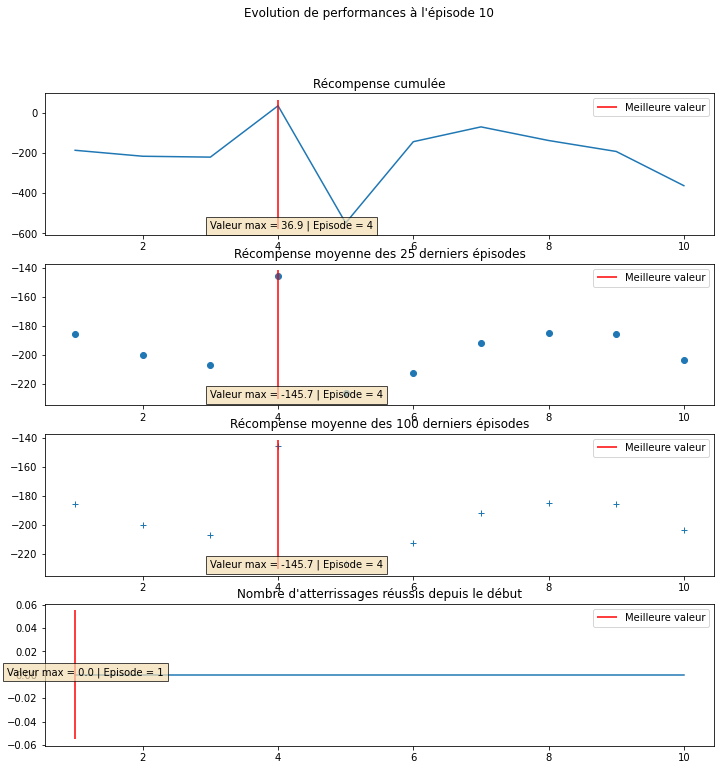

  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

####################################### Episode 11 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -53.100   |  161  | 6.5 secondes  |   -189.500    |   -189.500    |   -189.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 12 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -69.300   |  142  | 5.9 secondes  |   -179.500    |   -179.500    |   -179.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 13 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -159.900  |  113  | 5.0 secondes  |     -178      |     -178      |     -178      |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 14 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -229.800  |  84   | 3.5 secondes  |   -181.700    |   -181.700    |   -181.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 15 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -466.600  |  294  | 13.2 secondes |   -200.700    |   -200.700    |   -200.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 16 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -58.300   |  112  | 5.0 secondes  |   -191.800    |   -191.800    |   -191.800    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 17 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -197    |  88   | 4.0 secondes  |   -192.100    |   -192.100    |   -192.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 18 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -138.700  |  151  | 7.2 secondes  |   -189.100    |   -189.100    |   -189.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 19 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -57.200   |  126  | 5.6 secondes  |   -182.200    |   -182.200    |   -182.200    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 20 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -174.800  |  169  | 7.7 secondes  |   -181.800    |   -181.800    |   -181.800    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



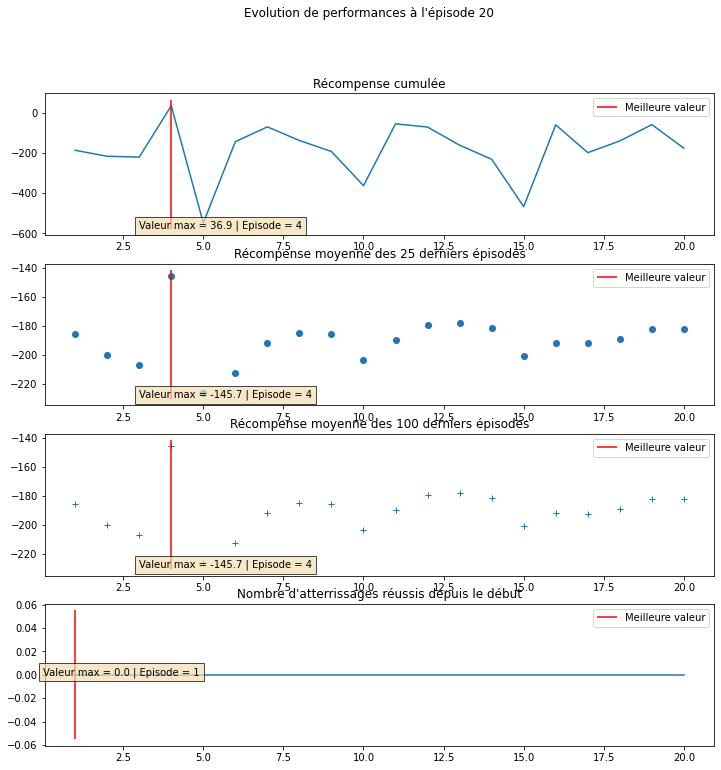

  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

####################################### Episode 21 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -113    |  147  | 6.9 secondes  |   -178.500    |   -178.500    |   -178.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 22 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:14

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -94.100   |  195  | 9.3 secondes  |   -174.700    |   -174.700    |   -174.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 23 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   12.300   |  300  | 14.4 secondes |   -166.500    |   -166.500    |   -166.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 24 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   6.600    |  179  | 8.7 secondes  |   -159.300    |   -159.300    |   -159.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 25 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -95     |  300  | 15.7 secondes |   -156.800    |   -156.800    |   -156.800    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 26 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -250    |  213  | 10.8 secondes |   -160.300    |   -160.300    |   -159.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 27 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   8.300    |  191  | 10.0 secondes |   -154.100    |   -154.100    |   -150.400    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 28 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -130.300  |  116  | 5.9 secondes  |   -153.200    |   -153.200    |   -146.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 29 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -64.800   |  122  | 6.3 secondes  |   -150.200    |   -150.200    |   -150.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 30 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08


[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   -7.700   |  161  | 8.4 secondes  |   -145.400    |   -145.400    |   -129.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



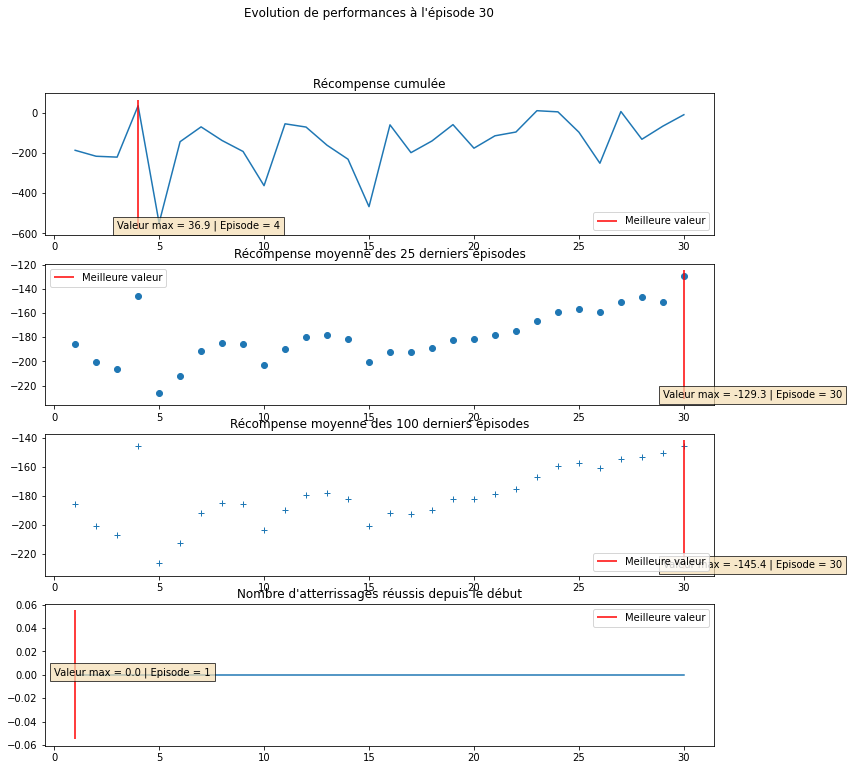

  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

####################################### Episode 31 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -315.600  |  162  | 8.3 secondes  |   -150.900    |   -150.900    |   -136.200    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 32 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -21.100   |  152  | 7.9 secondes  |   -146.900    |   -146.900    |   -134.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 33 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -224.300  |  190  | 10.0 secondes |   -149.200    |   -149.200    |   -137.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 34 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -138    |  80   | 4.2 secondes  |   -148.900    |   -148.900    |   -135.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 35 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -69.400   |  150  | 8.0 secondes  |   -146.600    |   -146.600    |     -124      |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 36 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:20

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -50.300   |  155  | 8.4 secondes  |   -143.900    |   -143.900    |   -123.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 37 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 36.9 (épisode 4)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -138.400  |  98   | 5.4 secondes  |   -143.800    |   -143.800    |   -126.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 38 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:14

[INFO] : Récompense obtenue améliorée de 36.9 (épisode 4) à 79.0

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     79     |  300  | 16.2 secondes |   -137.900    |   -137.900    |   -117.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=37_reward=79.h5 

####################################### Episode 39 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -93.100   |  99   | 5.1 secondes  |   -136.800    |   -136.800    |   -111.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 40 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -117.800  |  213  | 11.6 secondes |   -136.300    |   -136.300    |    -97.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



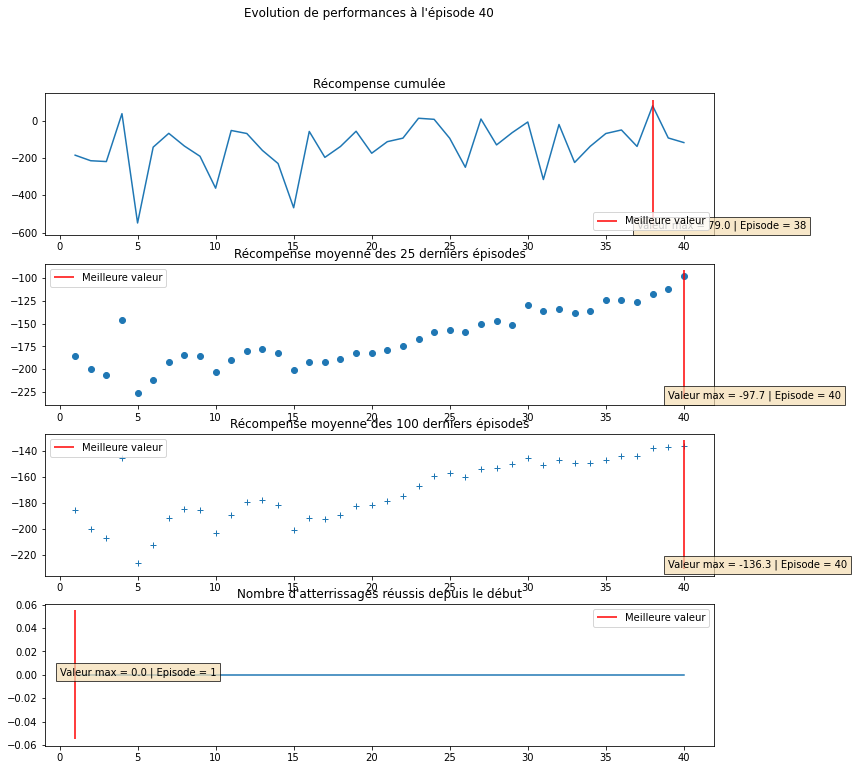

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 41 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -32     |  230  | 12.4 secondes |   -133.800    |   -133.800    |    -96.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 42 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -49.200   |  254  | 13.8 secondes |   -131.800    |   -131.800    |    -90.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 43 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:20

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -88     |  284  | 16.1 secondes |   -130.700    |   -130.700    |    -88.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 44 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -120    |  254  | 14.7 secondes |   -130.500    |   -130.500    |    -91.200    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 45 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -141.300  |  185  | 10.9 secondes |   -130.700    |   -130.700    |    -89.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 46 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -156.600  |  262  | 14.6 secondes |   -131.300    |   -131.300    |    -91.600    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 47 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -140.900  |  277  | 15.2 secondes |   -131.500    |   -131.500    |    -93.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 48 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -16.900   |  300  | 16.7 secondes |   -129.100    |   -129.100    |    -94.700    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 49 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   14.200   |  300  | 16.4 secondes |   -126.200    |   -126.200    |    -94.400    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 50 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   0.800    |  300  | 16.5 secondes |   -123.600    |   -123.600    |    -90.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



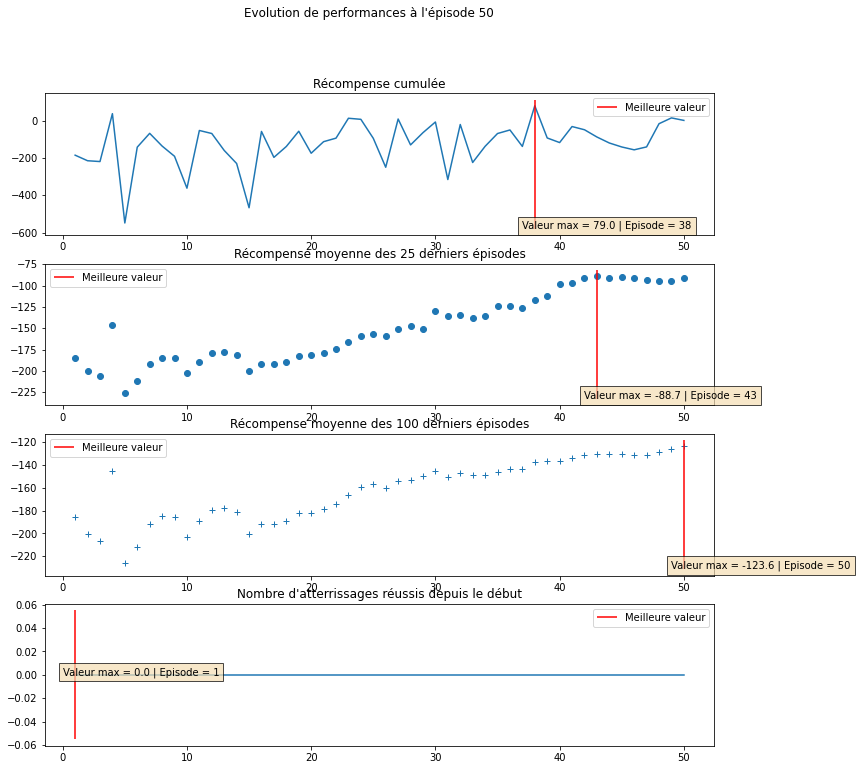

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 51 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   35.600   |  300  | 16.1 secondes |   -120.500    |   -119.200    |    -79.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 52 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -146.900  |  91   | 5.0 secondes  |     -121      |   -117.900    |    -85.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 53 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -19.100   |  300  | 16.4 secondes |   -119.100    |   -113.900    |    -80.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 54 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   17.600   |  300  | 16.4 secondes |   -116.600    |   -114.200    |    -77.600    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 55 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   10.700   |  300  | 16.8 secondes |   -114.300    |   -103.100    |    -76.800    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 56 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -138.600  |  290  | 15.9 secondes |   -114.700    |     -103      |    -69.800    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 57 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -91     |  182  | 10.0 secondes |   -114.300    |   -103.500    |    -72.600    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 58 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   44.700   |  300  | 16.2 secondes |   -111.500    |    -99.800    |    -61.800    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 59 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -28.800   |  300  | 16.3 secondes |   -110.100    |    -96.600    |    -57.400    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 60 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   54.500   |  300  | 16.4 secondes |   -107.400    |    -88.300    |    -52.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



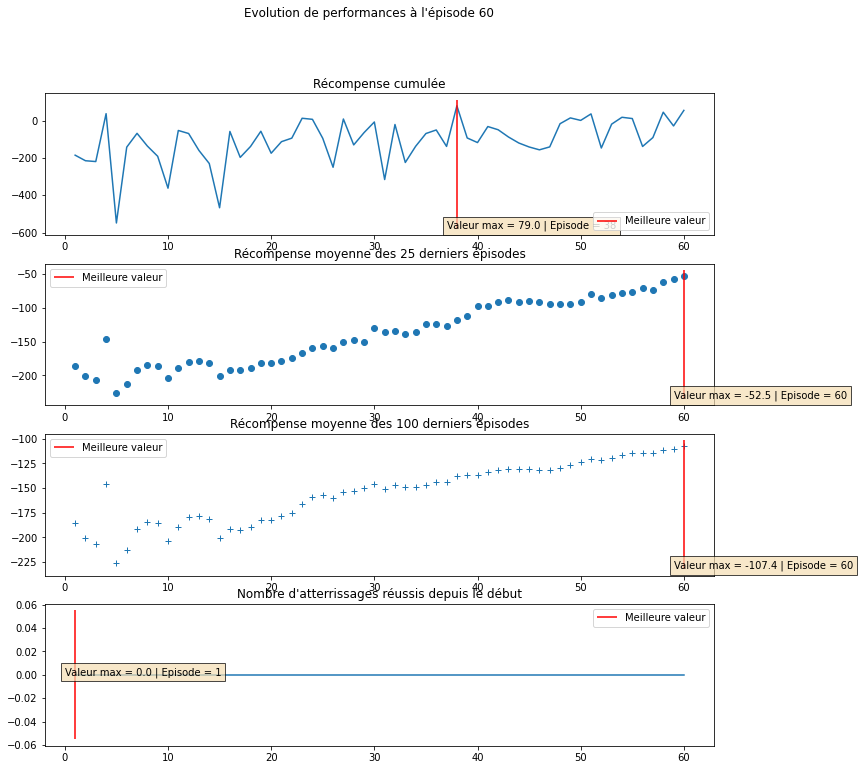

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

####################################### Episode 61 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:19

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   52.500   |  300  | 16.2 secondes |   -104.800    |    -86.100    |    -48.400    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 62 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   -1.500   |  300  | 17.5 secondes |   -103.100    |    -84.800    |    -42.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 63 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:19

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   49.200   |  300  | 16.6 secondes |   -100.700    |    -80.600    |    -44.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 64 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -26.400   |  300  | 16.9 secondes |    -99.500    |    -76.500    |    -41.400    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 65 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   1.400    |  300  | 16.9 secondes |      -98      |    -67.200    |    -36.600    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 66 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   51.200   |  300  | 17.0 secondes |    -95.700    |      -65      |    -33.300    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 67 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -13.600   |  300  | 17.2 secondes |    -94.500    |    -61.300    |    -31.900    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 68 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   46.200   |  300  | 16.6 secondes |    -92.400    |    -57.600    |    -26.500    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 69 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:19

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -35     |  300  | 16.4 secondes |    -91.600    |    -57.200    |    -23.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 70 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   34.300   |  300  | 16.2 secondes |    -89.800    |      -53      |    -16.100    |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



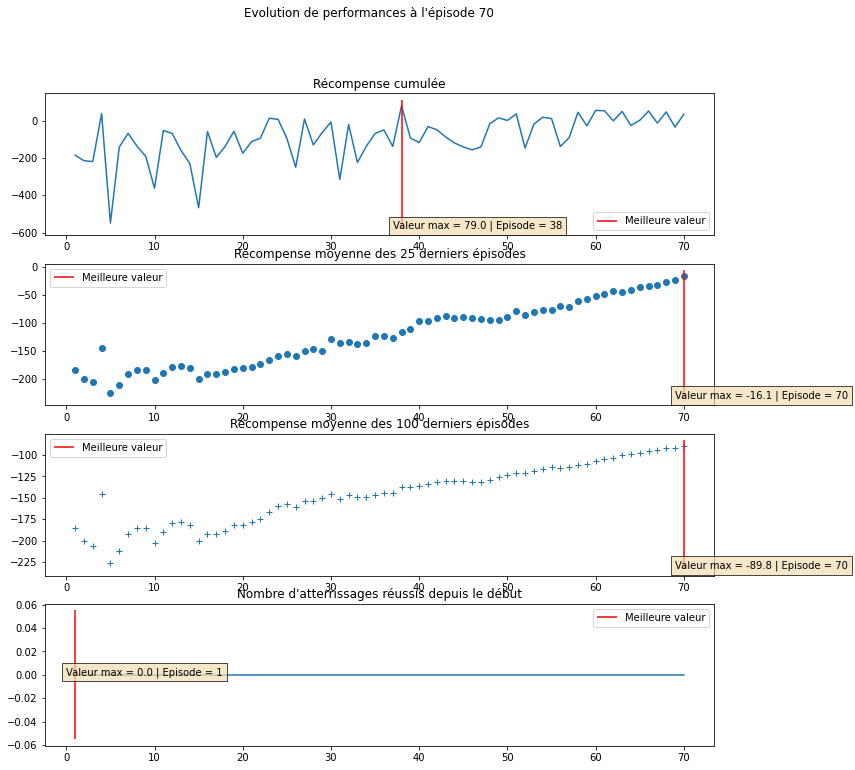

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

####################################### Episode 71 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   20.600   |  300  | 17.3 secondes |    -88.200    |    -50.300    |      -9       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 72 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   33.100   |  300  | 17.6 secondes |    -86.600    |    -47.800    |      -2       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 73 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   -1.500   |  300  | 17.2 secondes |    -85.400    |    -48.100    |    -1.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 74 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 79.0 (épisode 38)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   51.700   |  300  | 16.9 secondes |    -83.500    |    -47.200    |     0.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 75 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense obtenue améliorée de 79.0 (épisode 38) à 79.1

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   79.100   |  300  | 17.1 secondes |    -81.400    |    -43.700    |     3.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=74_reward=79.h5 

####################################### Episode 76 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 79.1 (épisode 75)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     61     |  300  | 16.4 secondes |    -79.500    |    -37.500    |     4.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 77 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense obtenue améliorée de 79.1 (épisode 75) à 81.6

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   81.600   |  300  | 17.4 secondes |    -77.400    |      -36      |    13.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=76_reward=82.h5 

####################################### Episode 78 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 81.6 (épisode 77)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -89.600   |  300  | 17.1 secondes |    -77.600    |    -35.200    |    10.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 79 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 81.6 (épisode 77)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   40.800   |  300  | 16.6 secondes |    -76.100    |    -33.100    |    11.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 80 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 81.6 (épisode 77)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   34.600   |  300  | 16.7 secondes |    -74.700    |    -32.200    |    12.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



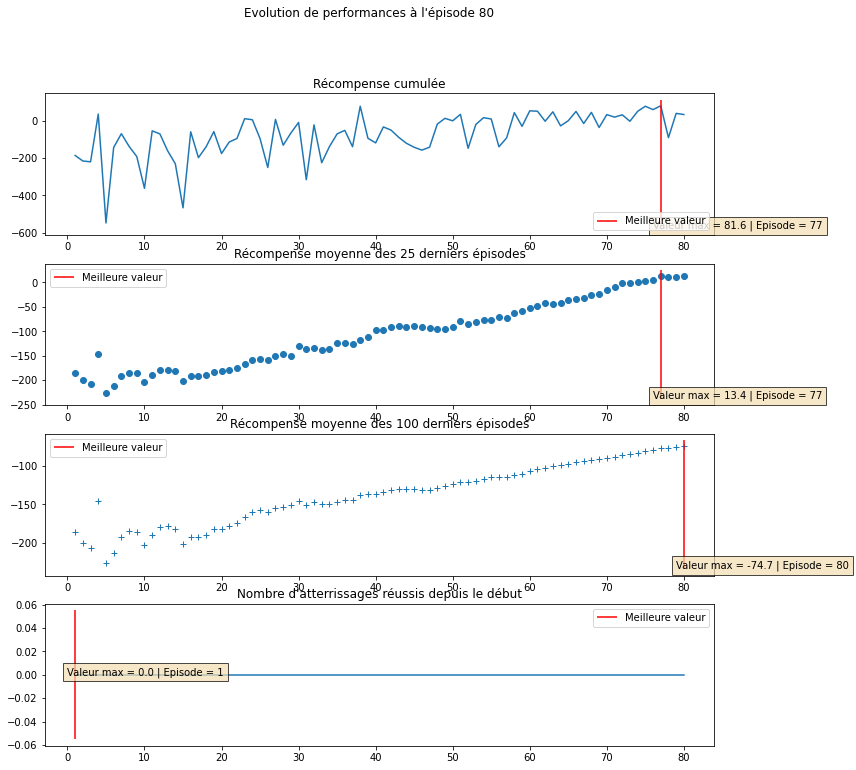

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 81 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 81.6 (épisode 77)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   60.600   |  300  | 17.0 secondes |      -73      |    -24.700    |    20.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 82 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense obtenue améliorée de 81.6 (épisode 77) à 85.6

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   85.600   |  300  | 17.3 secondes |    -71.100    |    -22.600    |    27.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=81_reward=86.h5 

####################################### Episode 83 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense obtenue améliorée de 85.6 (épisode 82) à 87.8

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   87.800   |  300  | 16.7 secondes |    -69.200    |    -16.300    |    29.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=82_reward=88.h5 

####################################### Episode 84 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:19

[INFO] : Récompense maximale obtenue jusqu'ici : 87.8 (épisode 83)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   63.900   |  300  | 17.2 secondes |    -67.600    |    -12.300    |    32.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 85 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense obtenue améliorée de 87.8 (épisode 83) à 101.1

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  101.100   |  300  | 17.9 secondes |    -65.600    |    -8.900     |    34.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=84_reward=101.h5 

####################################### Episode 86 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   40.100   |  300  | 17.0 secondes |    -64.400    |    -7.100     |    34.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 87 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   44.500   |  300  | 16.8 secondes |    -63.100    |    -3.400     |    36.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 88 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   65.400   |  300  | 16.9 secondes |    -61.600    |    -3.700     |    36.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 89 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     49     |  300  | 16.6 secondes |    -60.400    |    -0.800     |    39.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 90 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   91.600   |  300  | 16.5 secondes |    -58.700    |     3.400     |    43.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



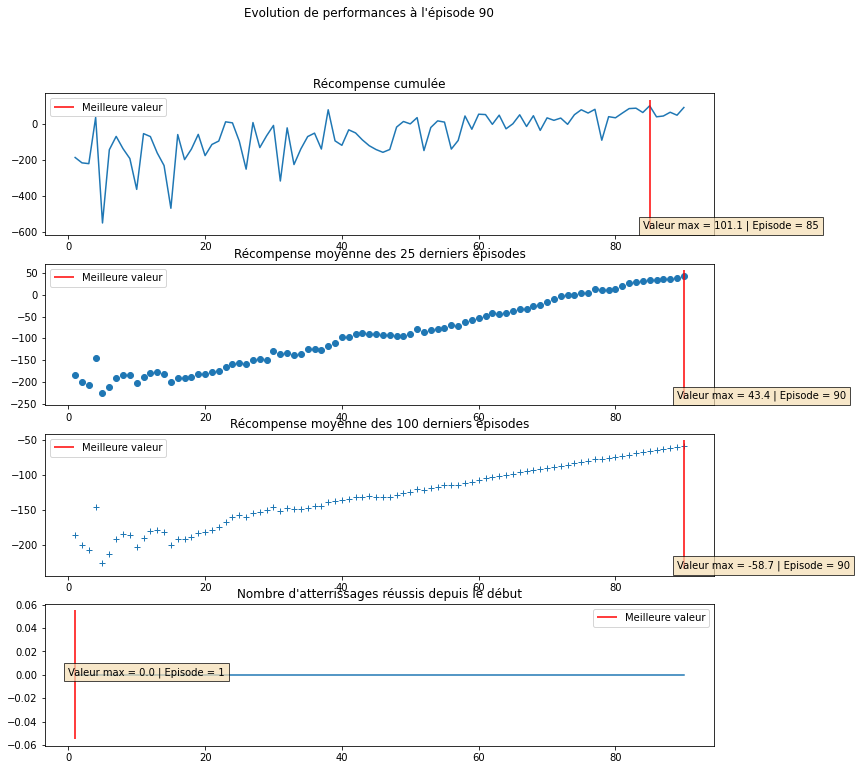

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 91 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   74.700   |  300  | 16.3 secondes |    -57.200    |     5.500     |    44.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 92 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   69.100   |  300  | 16.7 secondes |    -55.900    |     7.900     |    47.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 93 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   80.100   |  300  | 17.2 secondes |    -54.400    |    11.200     |      49       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 94 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:21

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  100.800   |  300  | 16.7 secondes |    -52.800    |    15.600     |    54.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 95 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   36.700   |  300  | 16.8 secondes |    -51.800    |    19.200     |    54.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 96 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 101.1 (épisode 85)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   39.200   |  300  | 16.9 secondes |    -50.900    |    23.100     |    55.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 97 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense obtenue améliorée de 101.1 (épisode 85) à 104.0

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    104     |  300  | 17.0 secondes |    -49.300    |      28       |    58.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=96_reward=104.h5 

####################################### Episode 98 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   94.900   |  300  | 17.2 secondes |    -47.800    |    30.300     |    61.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 99 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   57.600   |  300  | 17.0 secondes |    -46.700    |    31.100     |    62.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 100 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   20.600   |  300  | 17.0 secondes |    -46.100    |    31.500     |    59.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



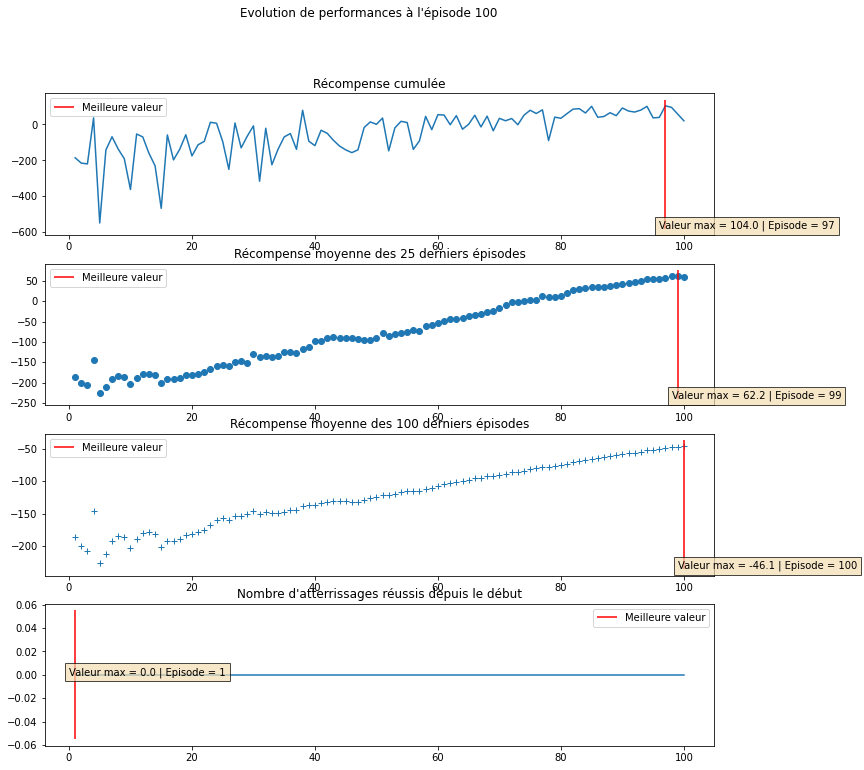

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

####################################### Episode 101 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:14

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   44.200   |  300  | 17.2 secondes |    -43.800    |    31.700     |    59.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 102 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   12.600   |  300  | 17.2 secondes |    -41.500    |    34.900     |    56.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 103 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:20

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   85.800   |  300  | 17.0 secondes |    -38.400    |      37       |    63.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 104 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   17.800   |  300  | 17.2 secondes |    -38.600    |      37       |    62.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 105 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   29.800   |  300  | 17.2 secondes |    -32.900    |    37.400     |    62.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 106 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   84.700   |  300  | 16.9 secondes |    -30.600    |    41.800     |    63.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 107 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 104.0 (épisode 97)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -78.800   |  300  | 17.7 secondes |    -30.700    |    42.100     |    56.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 108 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense obtenue améliorée de 104.0 (épisode 97) à 104.9

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  104.900   |  300  | 17.4 secondes |    -28.300    |    43.300     |    57.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=107_reward=105.h5 

####################################### Episode 109 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 104.9 (épisode 108)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  103.700   |  300  | 17.4 secondes |    -25.300    |    45.900     |      59       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 110 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


[INFO] : Récompense maximale obtenue jusqu'ici : 104.9 (épisode 108)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   55.100   |  300  | 17.1 secondes |    -21.200    |    45.900     |    57.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



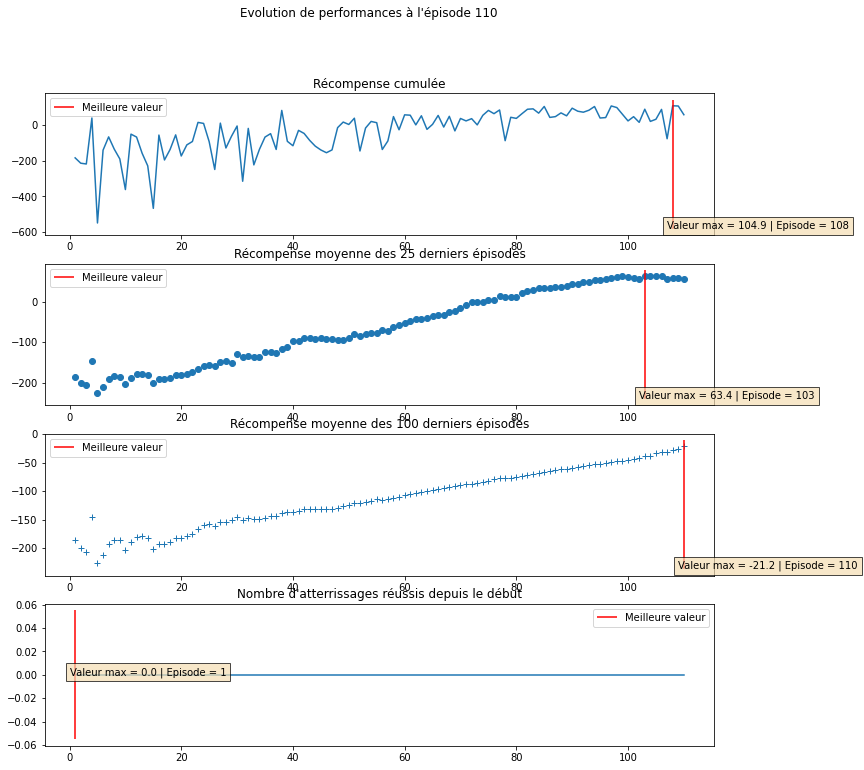

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

####################################### Episode 111 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 104.9 (épisode 108)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   62.700   |  300  | 16.6 secondes |      -20      |    46.100     |      58       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 112 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 104.9 (épisode 108)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   79.700   |  300  | 17.2 secondes |    -18.500    |    47.800     |    59.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 113 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense obtenue améliorée de 104.9 (épisode 108) à 106.9

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  106.900   |  300  | 17.6 secondes |    -15.800    |    48.900     |    61.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=112_reward=107.h5 

####################################### Episode 114 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:18 Time:  0:00:18
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 106.9 (épisode 113)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   76.600   |  300  | 18.3 secondes |    -12.800    |      51       |    62.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 115 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 106.9 (épisode 113)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   88.200   |  300  | 17.3 secondes |    -7.200     |    52.700     |    62.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 116 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 106.9 (épisode 113)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     26     |  155  | 8.9 secondes  |    -6.400     |    52.200     |    60.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 117 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 106.9 (épisode 113)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -147.300  |  73   | 4.3 secondes  |    -5.900     |    49.500     |    51.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 118 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense obtenue améliorée de 106.9 (épisode 113) à 118.5

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  118.500   |  300  | 16.4 secondes |    -3.300     |      51       |      53       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=117_reward=119.h5 

####################################### Episode 119 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  1% (3 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:14

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  103.600   |  300  | 16.8 secondes |    -1.700     |    53.800     |    53.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 120 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   32.400   |  300  | 16.9 secondes |     0.400     |    53.700     |    52.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



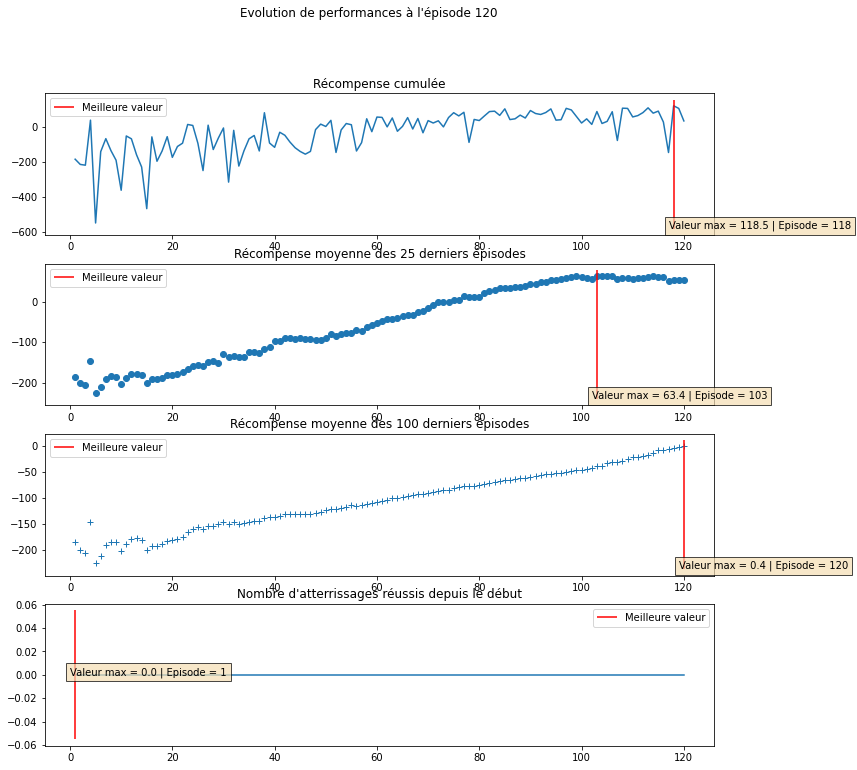

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 121 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   59.300   |  300  | 17.1 secondes |     2.100     |    54.500     |    53.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 122 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -26.200   |  300  | 16.9 secondes |     2.800     |    53.300     |    48.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 123 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   29.700   |  300  | 16.9 secondes |     2.900     |    53.900     |    45.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 124 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   46.200   |  300  | 17.0 secondes |     3.300     |    53.800     |    45.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 125 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   34.800   |  300  | 16.7 secondes |     4.600     |    52.900     |      46       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 126 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   59.400   |  300  | 16.8 secondes |     7.700     |    52.900     |    46.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 127 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     13     |  300  | 16.8 secondes |     7.800     |    51.500     |    46.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 128 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   83.800   |  300  | 17.0 secondes |     9.900     |      55       |    46.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 129 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -15.700   |  300  | 16.2 secondes |    10.400     |    53.900     |    45.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 130 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 118.5 (épisode 118)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   74.800   |  300  | 16.5 secondes |    11.200     |    54.700     |      47       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



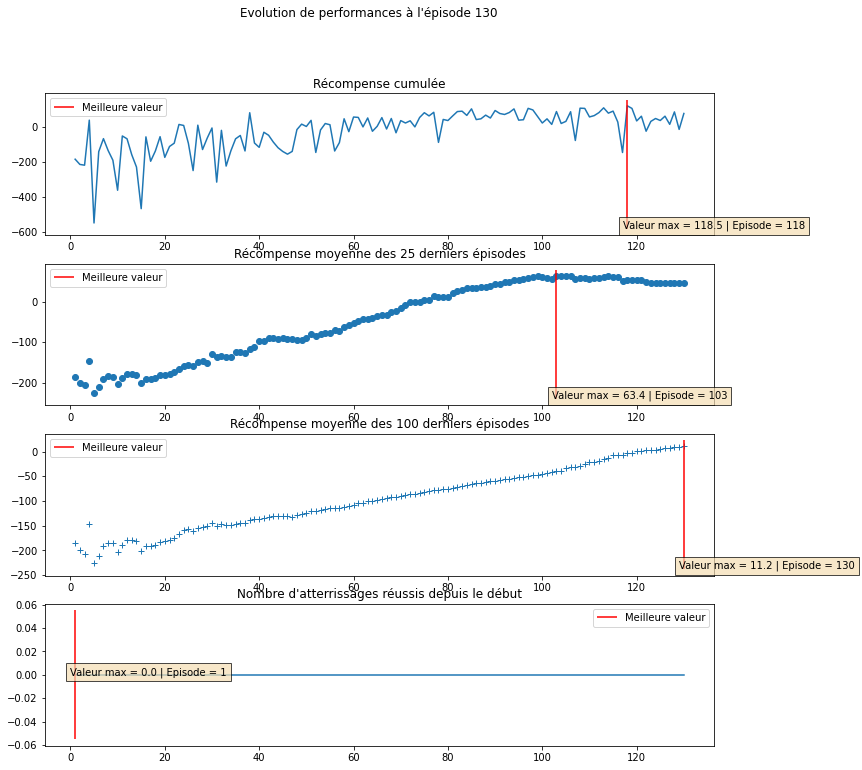

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 131 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense obtenue améliorée de 118.5 (épisode 118) à 119.7

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  119.700   |  300  | 17.0 secondes |    15.600     |    55.900     |    48.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=130_reward=120.h5 

####################################### Episode 132 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 119.7 (épisode 131)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   13.600   |  300  | 17.0 secondes |    15.900     |    54.400     |    52.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 133 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 119.7 (épisode 131)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     72     |  300  | 16.9 secondes |    18.900     |    54.100     |    50.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 134 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 119.7 (épisode 131)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   64.700   |  300  | 16.9 secondes |    20.900     |    54.100     |    49.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 135 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense obtenue améliorée de 119.7 (épisode 131) à 121.0

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    121     |  300  | 16.7 secondes |    22.800     |    54.500     |    51.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

[INFO] : Saving model to disk at  ./checkpoints/best_ep=134_reward=121.h5 

####################################### Episode 136 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  120.700   |  300  | 16.9 secondes |    24.500     |    56.100     |    54.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 137 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   67.500   |  300  | 17.0 secondes |    26.600     |    56.600     |    53.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 138 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  109.900   |  300  | 16.8 secondes |    26.900     |    57.500     |    53.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 139 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  101.400   |  300  | 17.1 secondes |    28.800     |    58.500     |    54.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 140 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   65.900   |  300  | 16.9 secondes |    30.700     |      58       |      54       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



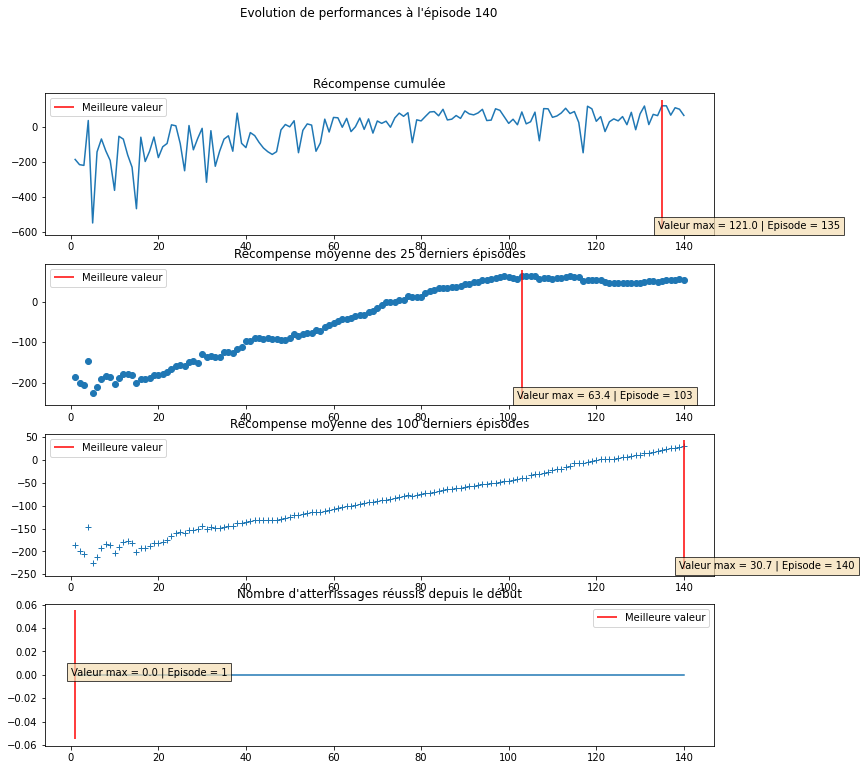

  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

####################################### Episode 141 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   73.900   |  300  | 16.7 secondes |    31.700     |      58       |    55.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 142 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   83.500   |  300  | 16.7 secondes |    33.100     |    58.300     |    65.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 143 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  101.100   |  300  | 16.9 secondes |      35       |    58.700     |    64.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 144 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     83     |  300  | 16.8 secondes |      37       |    58.300     |    63.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 145 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:18

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  102.400   |  300  | 17.4 secondes |    39.400     |    59.700     |    66.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 146 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   76.100   |  300  | 17.8 secondes |    41.800     |    60.400     |    67.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 147 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:18 Time:  0:00:18
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:21

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   24.800   |  300  | 18.4 secondes |    43.400     |    58.800     |    69.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 148 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:16

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  108.500   |  300  | 17.2 secondes |    44.700     |    59.100     |    72.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 149 / 500 ######################################################


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   82.200   |  300  | 17.2 secondes |    45.300     |    59.600     |    73.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 150 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   82.100   |  300  | 16.9 secondes |    46.200     |    60.800     |    75.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



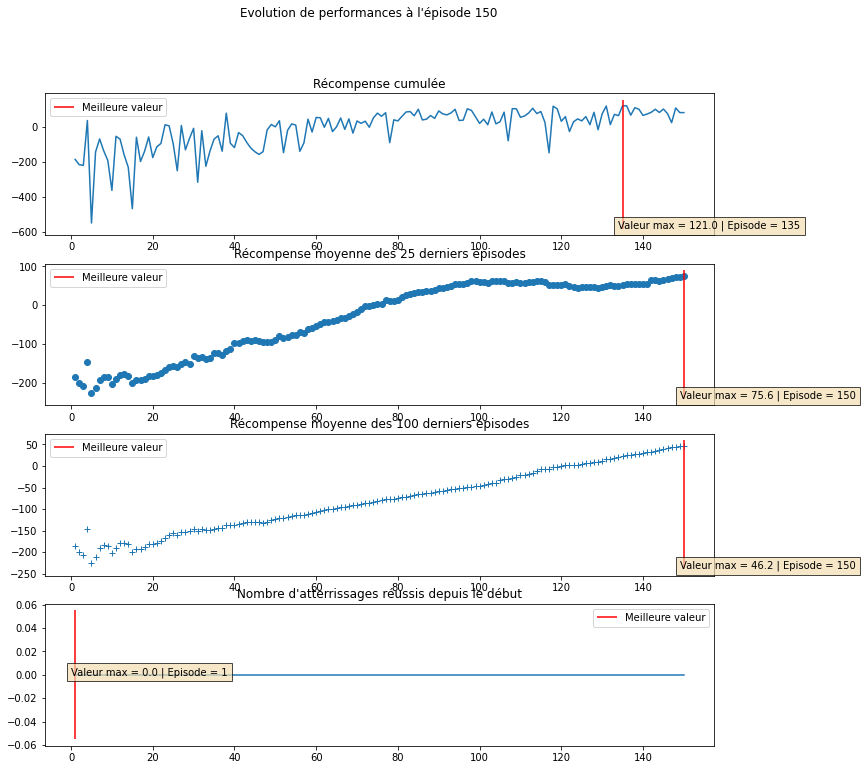

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

####################################### Episode 151 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   51.200   |  500  | 28.3 secondes |    46.300     |    60.900     |    75.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 152 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:32

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   43.400   |  500  | 28.8 secondes |    48.200     |    61.600     |    76.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 153 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:32

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   26.700   |  500  | 29.5 secondes |    48.700     |    60.400     |    74.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 154 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   65.200   |  500  | 29.7 secondes |    49.200     |    61.300     |    77.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 155 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     41     |  500  | 27.3 secondes |    49.500     |    61.500     |    76.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 156 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   38.900   |  500  | 28.7 secondes |    51.200     |    60.600     |    72.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 157 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -177.400  |  56   | 3.2 secondes  |    50.400     |    58.700     |    65.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 158 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -24.800   |  115  | 6.6 secondes  |    49.700     |    56.100     |    61.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 159 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -59     |  75   | 4.4 secondes  |    49.400     |    52.800     |    56.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 160 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  104.800   |  500  | 28.4 secondes |    49.900     |    53.800     |    55.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



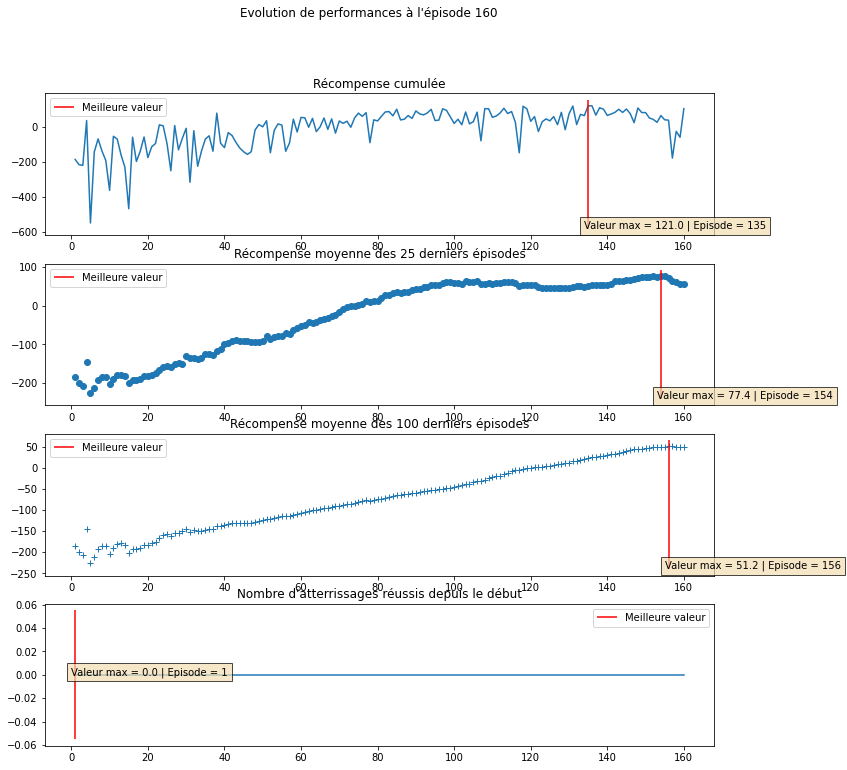

  0% (4 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:24

####################################### Episode 161 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -112.600  |  97   | 5.3 secondes  |    48.200     |    50.300     |    46.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 162 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   67.900   |  500  | 27.6 secondes |    48.900     |    50.100     |    46.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 163 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   36.100   |  500  | 28.6 secondes |    48.800     |    48.700     |    43.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 164 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   -4.600   |  500  | 27.1 secondes |      49       |      47       |    39.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 165 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   28.500   |  500  | 26.8 secondes |    49.300     |    45.800     |    37.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 166 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   5.300    |  500  | 27.6 secondes |    48.800     |    45.400     |      35       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 167 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -24.500   |  500  | 28.6 secondes |    48.700     |    47.900     |    30.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 168 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   46.700   |  500  | 28.6 secondes |    48.700     |    46.400     |    28.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 169 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -177.100  |  156  | 9.0 secondes  |    47.300     |    40.800     |    18.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 170 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   10.600   |  500  | 28.3 secondes |    47.100     |    40.400     |    14.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



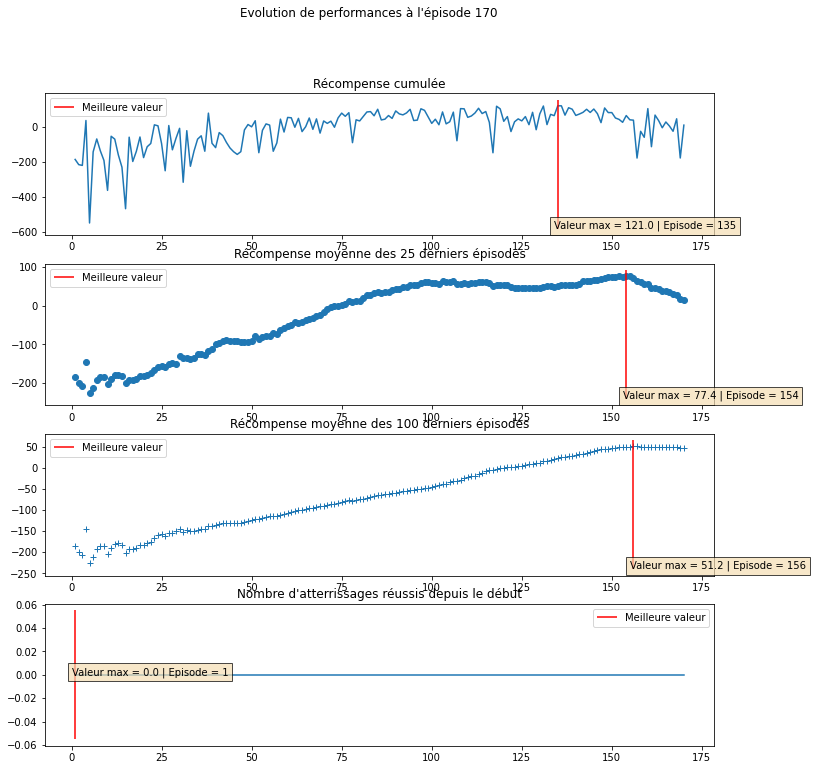

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

####################################### Episode 171 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   65.200   |  500  | 27.1 secondes |    47.500     |    40.500     |      14       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 172 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:16 Time:  0:00:16
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|    -219    |  290  | 16.6 secondes |      45       |    36.700     |     4.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 173 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   59.900   |  500  | 28.6 secondes |    45.600     |    37.300     |     2.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 174 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   62.600   |  500  | 28.5 secondes |    45.700     |    37.600     |     1.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 175 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   33.500   |  500  | 27.9 secondes |    45.200     |    37.600     |    -0.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 176 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   5.300    |  500  | 26.9 secondes |    44.700     |    36.500     |    -2.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 177 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   16.500   |  500  | 30.6 secondes |      44       |    36.500     |    -3.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 178 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   39.300   |  500  | 29.1 secondes |    45.300     |    35.700     |    -2.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 179 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   68.200   |  500  | 28.5 secondes |    45.600     |    37.300     |    -2.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 180 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   55.400   |  500  | 28.7 secondes |    45.800     |      37       |    -2.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



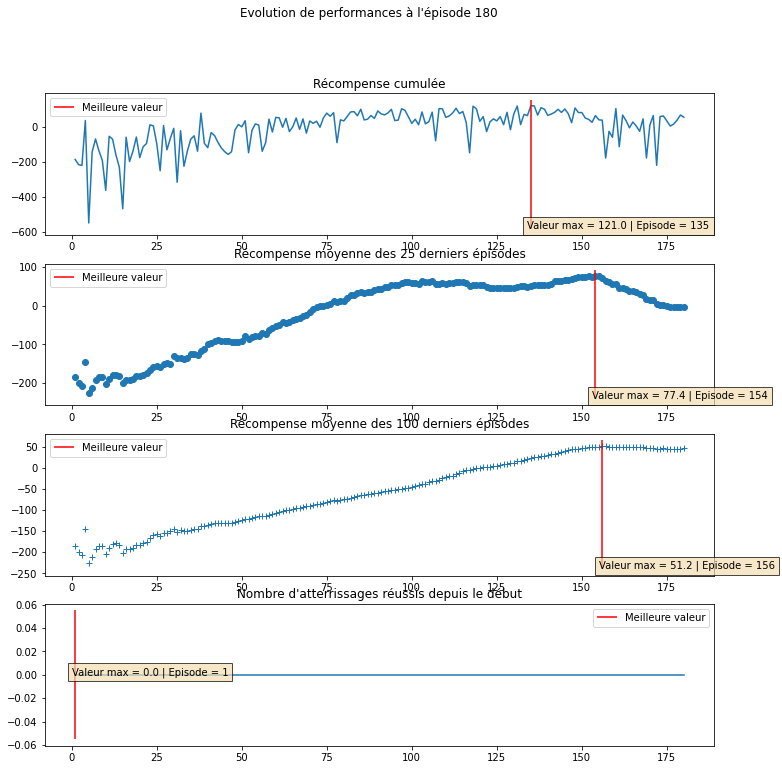

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:32

####################################### Episode 181 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   87.500   |  500  | 28.5 secondes |    46.100     |    36.300     |    -0.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 182 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   89.600   |  500  | 28.2 secondes |    46.100     |    37.800     |    10.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 183 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:37

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -91.700   |  472  | 28.9 secondes |    44.300     |    34.600     |     7.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 184 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   46.600   |  500  | 30.6 secondes |    44.200     |    34.200     |      12       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 185 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   22.400   |  500  | 30.6 secondes |    43.400     |    32.200     |     8.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 186 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   24.700   |  500  | 30.5 secondes |    43.200     |    30.300     |    14.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 187 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -14.800   |  500  | 28.2 secondes |    42.600     |    28.700     |    10.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 188 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:38

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   49.500   |  500  | 28.5 secondes |    42.500     |    27.400     |    11.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 189 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   13.900   |  500  | 29.0 secondes |    42.100     |    25.700     |    12.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 190 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   49.100   |  500  | 28.6 secondes |    41.700     |    25.400     |      13       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



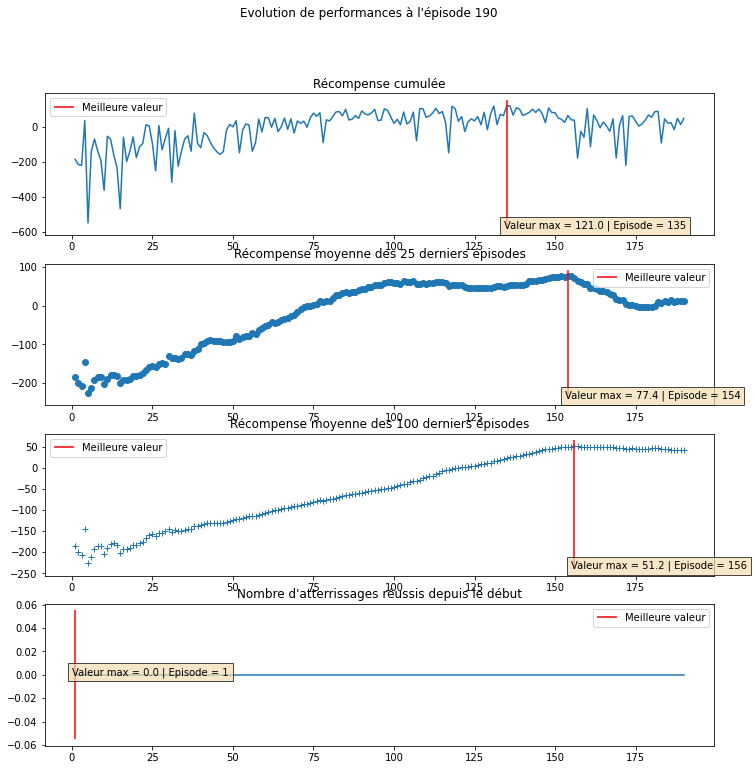

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

####################################### Episode 191 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   2.400    |  500  | 28.8 secondes |      41       |    23.900     |    12.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 192 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   35.500   |  500  | 28.9 secondes |    40.600     |      23       |    15.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 193 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:31

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   27.700   |  500  | 28.9 secondes |    40.100     |    21.500     |    14.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 194 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     36     |  500  | 28.8 secondes |    39.500     |    20.600     |      23       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 195 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   98.200   |  500  | 27.9 secondes |    40.100     |    20.500     |    26.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 196 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   73.700   |  500  | 28.1 secondes |    40.400     |    20.400     |    26.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 197 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -21.300   |  500  | 28.6 secondes |    39.200     |    19.500     |    34.800     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 198 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   81.700   |  500  | 28.3 secondes |      39       |      19       |    35.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 199 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   49.300   |  500  | 28.9 secondes |    38.900     |    18.300     |    35.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 200 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   20.400   |  500  | 28.0 secondes |    38.900     |    17.100     |    34.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



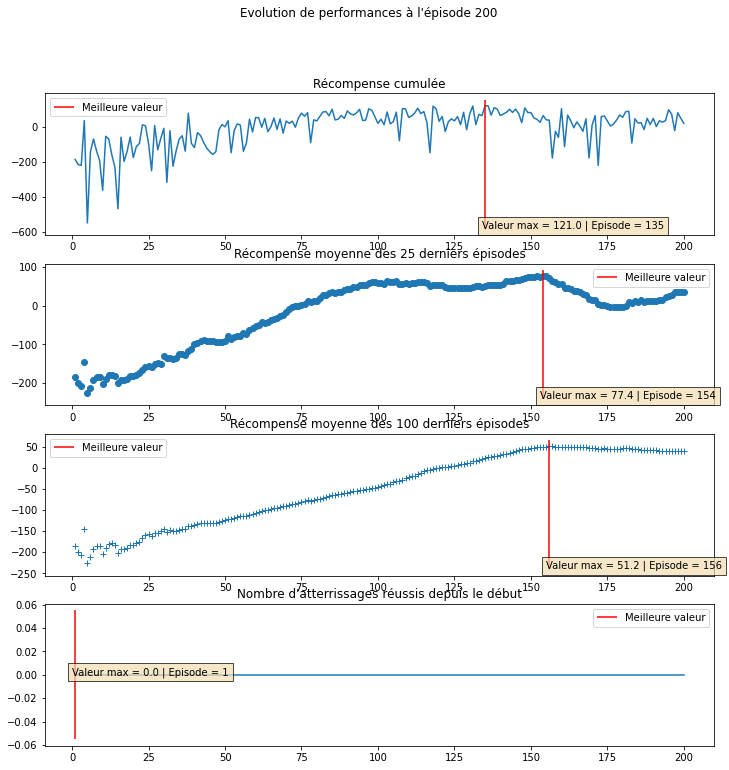

  0% (3 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:24

####################################### Episode 201 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   76.200   |  500  | 28.0 secondes |    39.300     |    17.600     |    37.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 202 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   48.800   |  500  | 28.6 secondes |    39.600     |    17.700     |    38.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 203 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   76.800   |  500  | 28.5 secondes |    39.500     |    18.700     |    40.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 204 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   46.200   |  500  | 28.6 secondes |    39.800     |    18.300     |    39.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 205 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   65.400   |  500  | 28.2 secondes |    40.200     |    18.800     |    39.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 206 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:31 Time:  0:00:31
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   78.400   |  500  | 31.6 secondes |    40.100     |    19.600     |    39.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 207 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   52.500   |  500  | 28.8 secondes |    41.400     |    24.200     |    37.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 208 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (3 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:23

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     26     |  500  | 28.8 secondes |    40.600     |    25.200     |    42.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 209 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   69.800   |  500  | 28.9 secondes |    40.300     |    27.800     |    43.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 210 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     34     |  500  | 29.3 secondes |    40.100     |    26.400     |      44       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



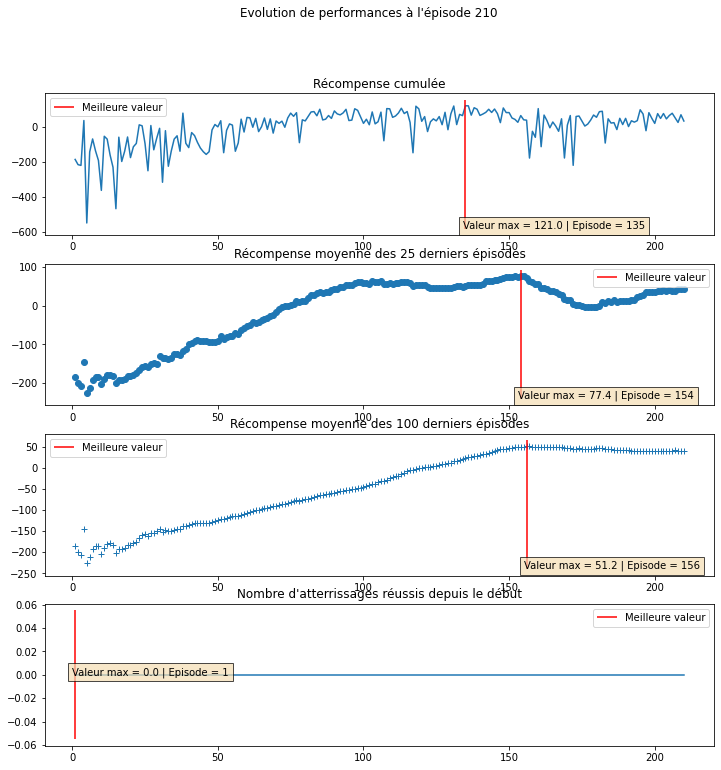

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

####################################### Episode 211 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:31

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   76.700   |  500  | 28.6 secondes |    40.200     |    30.100     |    46.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 212 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   92.200   |  500  | 28.4 secondes |    40.300     |    30.600     |    50.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 213 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   12.200   |  500  | 29.2 secondes |    39.400     |    30.100     |    48.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 214 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   10.900   |  500  | 27.6 secondes |    38.700     |    30.500     |    48.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 215 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   85.500   |  500  | 29.3 secondes |    38.700     |    31.600     |    50.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 216 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   45.500   |  500  | 29.3 secondes |    38.900     |    32.400     |    51.900     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 217 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   63.900   |  500  | 29.3 secondes |      41       |    34.200     |    53.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 218 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   39.300   |  500  | 28.8 secondes |    40.200     |      34       |    53.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 219 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -44.200   |  97   | 5.5 secondes  |    38.800     |    36.700     |    50.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 220 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   79.700   |  500  | 29.1 secondes |    39.200     |    38.100     |    49.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



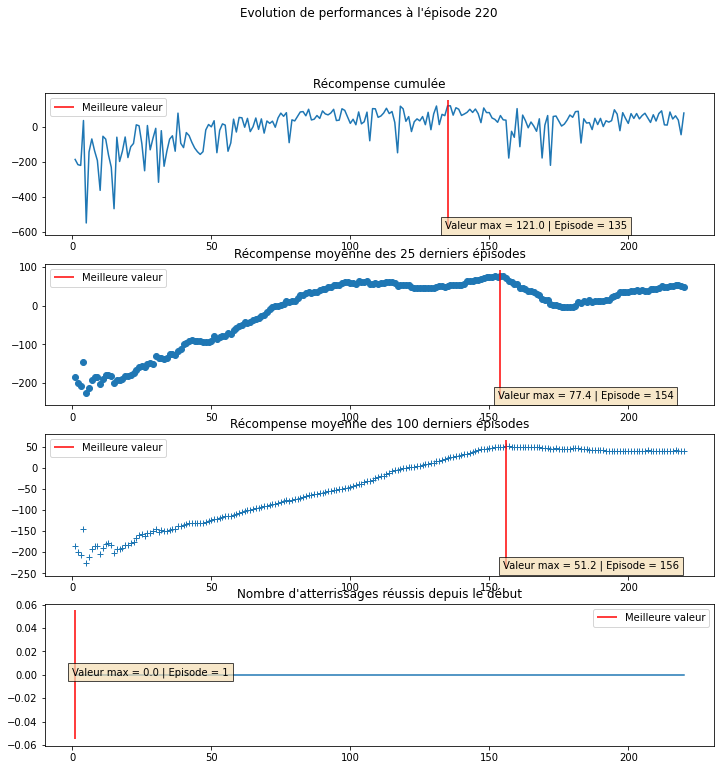

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:25

####################################### Episode 221 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (3 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:23

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   98.700   |  500  | 29.0 secondes |    39.600     |    38.700     |    50.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 222 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   43.400   |  500  | 28.8 secondes |    40.300     |      44       |    53.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 223 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:31

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -173.200  |  139  | 7.5 secondes  |    38.300     |    39.300     |      43       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 224 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   83.600   |  500  | 28.7 secondes |    38.700     |    39.700     |    44.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 225 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  118.300   |  500  | 28.9 secondes |    39.500     |    41.400     |    48.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 226 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   78.400   |  500  | 28.8 secondes |    39.700     |    42.900     |    48.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 227 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     33     |  500  | 29.2 secondes |    39.900     |    43.200     |    47.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 228 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   11.200   |  500  | 29.0 secondes |    39.200     |    42.700     |    45.100     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 229 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   33.100   |  500  | 28.6 secondes |    39.600     |      42       |    44.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 230 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  -40.600   |  500  | 28.7 secondes |    38.500     |      40       |    40.300     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 



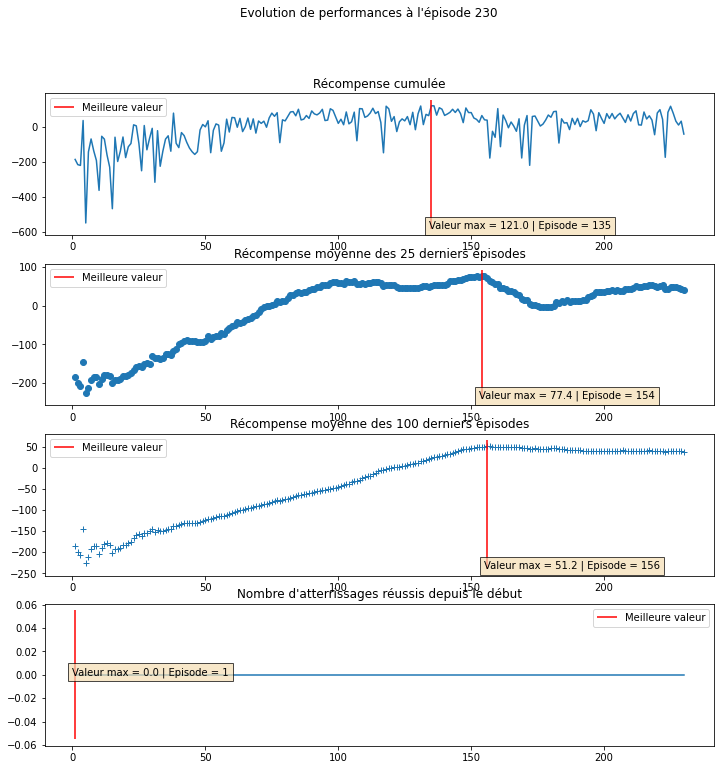

  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

####################################### Episode 231 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|  113.900   |  500  | 28.9 secondes |    38.400     |    40.600     |    41.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 232 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   96.800   |  500  | 28.9 secondes |    39.300     |    40.700     |    43.500     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 233 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   42.700   |  500  | 29.3 secondes |      39       |    43.400     |    44.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 234 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:26

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   5.100    |  500  | 30.3 secondes |    38.400     |    42.600     |    41.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 235 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:30

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   68.500   |  500  | 29.1 secondes |    37.900     |    43.500     |      43       |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 236 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   66.800   |  500  | 29.7 secondes |    37.300     |    44.300     |    42.600     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 237 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:32

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   8.700    |  500  | 29.4 secondes |    36.700     |    44.800     |    39.200     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 238 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|   41.100   |  500  | 29.0 secondes |      36       |    44.600     |    40.400     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 239 / 500 ######################################################


100% (500 of 500) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
  0% (2 of 500) |                        | Elapsed Time: 0:00:00 ETA:   0:00:27

[INFO] : Récompense maximale obtenue jusqu'ici : 121.0 (épisode 135)

+------------+-------+---------------+---------------+---------------+---------------+-------------+
| Récompense | Steps |   Durée de    |  Récompense   |  Récompense   |  Récompense   | Atterissage |
|            |       |   l'épisode   |  moy. [100]   |   moy. [50]   |   moy. [25]   |             |
+============+=======+===============+===============+===============+===============+=============+
|     43     |  500  | 27.8 secondes |    35.500     |    45.200     |    41.700     |      0      |
+------------+-------+---------------+---------------+---------------+---------------+-------------+ 

####################################### Episode 240 / 500 ######################################################


 20% (101 of 500) |####                  | Elapsed Time: 0:00:05 ETA:   0:00:23

In [ ]:
for episode in range(episodes):

    # A chaque épisode, on ré-initialise l'état de l'environnement
    state = env.reset()

    # La conséquence de l'initialisation est que le jeu ne peut pas être terminé, donc done=False
    done = False

    # On initialise à 0 la variable steps qui est le compteur du nombre d'étapes (et donc d'actions) réalisés
    # au cours d'un épisode
    episode_steps = 0

    # On initialise à 0 la durée de l'épisode
    episode_duration = 0

    # On initialise la récompense cumulée sur un episode
    total_reward = 0

    # On initialise le nombre d'atterissages réussis
    sucessfull_landings = 0

    # On calcule le nombre de steps maximum à réaliser pour l'épisode en cours
    max_steps = get_max_steps(episode)


    # On initialise les bars de progression
    episode_bar = progressbar.ProgressBar()
    episode_bar.start(max_value=get_max_steps(episode+1))

    # On affiche l'épisode en cours
    print("\033[1m" + "\033[94m" + "###"*13 + " Episode {} / {} ".format(episode+1, episodes) + "###"*18 + "\033[00m" + "\033[0;0m")

    # On lance le chronomètre pour cet épisode
    t0 = time.time()

    # On commence par itérer tant que l'épisode n'est pas terminé
    while not done:

        # Si l'attribut render est à True on affiche l'environnement
        if agent.render:
            env.render()

        # On incrémente les compteurs
        overall_steps += 1
        episode_steps += 1

        # L'agent choisit l'action à entreprendre
        action = agent.choose_action(state)

        # On applique l'action à l'environnement et on récupère les informations de transition
        next_state, reward, done, _ = env.step(action)

        # On stocke les informations de transition (S, A, R, S', D) dans le replay_buffer
        agent.store_transition(state, action, reward, next_state, done)

        # Une fois les informations stockées, on entraine l'agent sur un échantillon aléatoire du replay_buffer
        agent.train_on_batch()

        # Chaque 'agent.update_rate' steps, on transfère les poids du modèle policy vers le modèle target
        if overall_steps % agent.update_rate == 0:
            agent.update_target_model()

        # On réduit la valeur epsilon le facteur d'exploration
        agent.perform_epsilon_decay()


        # On incrémente la récompense cumulée sur un épisode        # Si l'attribut render est à True on affiche l'environnement
        if agent.render:
…            agent.update_target_model()

        # On réduit la valeur epsilon le facteur d'exploration
        agent.perform_epsilon_decay()


        total_reward += reward

        # Si la récompense immédiate reçue à la fin de l'épisode est +100, alors l'atterissage est réussi
        #
        if done and reward == 100:
            sucessfull_landings += 1

        # On arrête le chronomètre lorsque l'épisode est terminé ou qu'on a dépassé le nombre max de steps
        if episode_steps >= max_steps or done:
            episode_duration = time.time() - t0


        # On passe à l'état suivant et on continue d'itérer dans la boucle de l'épisode
        state = next_state

        # On appelle la fonction display_metrics pour gérer l'affichage de la progression de l'entrainement
        # On récupère la variable is_better pour savoir si l'agent a progressé
        is_better = display_metrics(total_reward        = total_reward,
                                    sucessfull_landings = sucessfull_landings,
                                    episode_duration    = episode_duration,
                                    episode_bar         = episode_bar,
                                    current_step        = episode_steps,
                                    done                = done,
                                    max_steps           = max_steps)

        # On enregistre le modèle sur le disque s'il y a eu amélioration de la récompense cumulée obtenue
        if is_better:
            agent.save("./checkpoints/best_ep={}_reward={:.0f}.h5".format(episode, total_reward))

        # On applique la stratégie d'apprentissage pour arrêter ou non les itérations d'entrainement
        # lors d'un épisode
        if episode_steps >= max_steps:
            break



<h2 style="text-align: left; color:#0099cc;font-size: 25px"><span>🤖 <strong>5. Evaluation de l'agent DQN</strong></span></h2>

In [ ]:
def display_test_metrics(total_rewards_list,
                         number_steps_list,
                         sucessfull_landings_list,
                         episode_duration_list,
                         episode,
                         episodes_max,
                         done,
                         episode_bar):

        '''
        Fonction permettant d'afficher la progression de l'évaluation del'agent à chaque action réalisée,
        d'afficher un récapitulatif des performances à chaque fin d'épisode, et d'afficher les statistiques
        d'évaluation à la fin du test.

                Parameters:

                        - total_reward_list (List) : Liste Python représentant la liste des récompenses cumulée
                                                     à chaque épisode de l'évaluation
                        - number_steps_list (List) : Liste Python représentant la liste du nombre de steps
                                                     pour chaque épisode de l'évaluation

                        - sucessfull_landings (list) : Liste Python représentant à chaque épisode de l'évaluation
                                                       le nombre d'atterrissages réussis depuis le début
                                                       de l'évaluation
                        - episode_duration_list (List) : Liste Python représentant la liste des durées d'épisodes
                        - episode (Int) : Nombre entier représentant le numéro de l'épisode actuel
                        - episodes_max (Int) : Nombre entier représentant le nombre maximum d'épisodes à réaliser
                                               pour l'évaluation
                        - done (Booléen) : Booléen représentant si l'épisode est terminé ou non
                        - episode_bar (ProgressBar()) : Objet ProgressBar() représentant un widget destiné à
                                                        afficher la progression de l'entrainement




                Returns:
                        - Rien : la fonction affiche les statistiques de l'évaluation et la progression de
                                 l'évaluation
    '''

    # Premier cas de traitement : l'épisode est terminé
    if done:
        # Dans le cas où l'épisode est terminé, on affiche les statistiques de l'épisode

        # Dans cette partie, on va afficher à la fin d'un épisode des statistiques sur la performance de l'agent
        # On utilise un objet Texttable de largeur maximum 100 pixels
        t = Texttable(max_width=140)

        # On centre l'ensemble des colonnes avec l'argument "c"
        t.set_cols_align(["c", "c", "c", "c", "c"])

        # On rajoute et on affiche les statistiques
        t.add_rows([['Episode', 'Récompense cumulée', "Durée de l'épisode", 'Nombre de steps', 'Atterrissages réussis'],
                    ['Episode {}'.format(episode+1),
                     "{:.1f}".format(total_rewards_list[-1]),
                     "{:.1f} secondes".format(episode_duration_list[-1]),
                     "{:.1f}".format(number_steps_list[-1]),
                     np.sum(sucessfull_landings_list)]])
        print(t.draw(), "\n")

        # Lorsque l'évaluation est terminée, on affiche le résumé de l'évaluation (moyennes des performances)
        if episode+1 == episodes_max:
            print("\033[1m" + "\033[91m" + "###"*13 + " RECAPITULATIF ".format(episode+1, episodes_max) + "###"*18 + "\033[00m" + "\033[0;0m")

            t = Texttable(max_width=110)
            t.set_cols_align(["c", "c", "c", "c", "c"])
            t.add_rows([["Nombre d'épisodes", 'Récompense cumulée moyenne', "Durée moyenne d'un épisode", 'Nombre moyen de steps', "Taux d'atterrissages réussis"],
            ['{}'.format(episodes_max),
             "{:.1f}".format(np.mean(total_rewards_list)),
             "{:.1f} secondes".format(np.mean(episode_duration_list)),
             "{:.1f}".format(int(np.mean(number_steps_list))),
             "{:.1%}".format(np.sum(sucessfull_landings_list)/episodes_max)]])
            print("\033[1m" + "\033[91m" + t.draw() + "\n")



    else:
        # Si l'épisode est toujours en cours, on affiche juste la progression
        episode_bar.update()


In [ ]:
class DQNTestAgent(DQNAgent):

    """
    Classe de l'agent DQN implémentant l'algorithme Deep Q-Network utilisé pour l'évaluation.
    Cette classe hérite de la classe DQNAgent
    """

    # On instancie la classe DQNTestAgent à partir de la classe DQNAgent
    def __init__(self):
        super().__init__(state_size, action_size)

    #
    # Méthode pour tester l'agent sur un nombre donné d'épisodes
    #
    def test(self, env, episodes_max, render=False):
        '''
        Fonction permettant de tester l'agent sur un certain nombre d'épisodes

                Parameters:

                        - env (Gym Env) : Environnement Gym représentant l'environnement de test.
                        - episodes_max (Int) : Nombre entier représentant le nombre maximum d'épisodes à réaliser
                                               pour l'évaluation
                        - render (Booléen) : Booléen indiquant si l'on souhaite afficher le jeu pendant l'évaluation


                Returns:
                        - Rien : réalise le test de l'agent (choisit les actions, applique à l'environnement),
                                 et affiche les performances de l'agent
    '''

        # On commence par initialiser les listes d'enregistrements

        # Liste d'enregistrement des récompenses obtenues à chaque épisode
        total_rewards_list = list()

        # Liste d'enregistrement des nombres de steps par épisode
        number_steps_list = list()

        # Liste d'enregistrement du nombre d'atterrissages réussis après chaque épisode
        sucessfull_landings_list = list()

        # Liste d'enregistrement des durées de chaque épisode
        episode_duration_list = list()

        # On initialise la bar de progression
        episode_bar = progressbar.ProgressBar()

        # On commence par itérer sur l'ensemble des épisodes de l'évaluation
        for episode in range(episodes_max):

            # En début d'épisode, on ré-initialise l'environnement
            state = env.reset()

            # On élargit le vecteur d'état (8) --> (1,8)
            # Cela sert à avoir un vecteur d'états prêt pour être utilisé en entrée du réseau de neurones
            state = tf.expand_dims(state, axis=0)

            # L'épisode n'est pas démarré, donc il ne peut être terminé, donc done = False
            done = False

            # On initialise le compteur de steps à 0
            episode_steps=0

            # Pareil pour la récompense cumulée par épisode
            total_reward=0

            # On affiche les données relatives à l'épisode en cours
            print("\033[1m" + "\033[94m" + "###"*13 + " Episode {} / {} ".format(episode+1, episodes_max) + "###"*18 + "\033[00m" + "\033[0;0m")

            # On initialise le compteur de durée
            t0 = time.time()

            # On itère en boucle tant que l'épisode n'est pas terminé
            while not done:

                # Si la variable render est à True, on affiche le rendu de l'environnement
                if render:
                    env.render()

                # Pour l'état en cours, l'agent choisit la meilleure action possible
                a = np.argmax(self.policy_model.predict(state))

                # La meilleure action est appliquée à l'environnement
                # L'environnement en retour donne les informations de la transition
                next_state, reward, done, _ = env.step(a)

                # On incrémente le compteur de steps
                episode_steps += 1

                # On incrémente la récompense cumulée avec la récompense immédiate reçue de l'environnement
                total_reward += reward

                # Si l'épisode est terminé
                if done :

                    # On calcule la durée de l'épisode
                    episode_duration = round(time.time()-t0, 1)

                    # On rajoute les valeurs de performance dans les différentes listes d'enregistrement
                    episode_duration_list.append(episode_duration)
                    total_rewards_list.append(total_reward)
                    number_steps_list.append(episode_steps)

                    # Si la récompense obtenue à la fin de l'épisode est de +100
                    # alors cela veut dire que l'atterrissage est réussi
                    if reward == 100:
                        sucessfull_landings_list.append(1)
                    else:
                        sucessfull_landings_list.append(0)

                # On appelle la fonction display_test_metrics pour gérer l'affichage de la progression de l'évaluation
                display_test_metrics(total_rewards_list       = total_rewards_list,
                                     number_steps_list        = number_steps_list,
                                     sucessfull_landings_list = sucessfull_landings_list,
                                     episode_duration_list    = episode_duration_list,
                                     episode                  = episode,
                                     episodes_max             = episodes_max,
                                     done                     = done,
                                     episode_bar              = episode_bar)

                # On change d'état avant de continuer l'itération
                state = tf.expand_dims(next_state, axis=0)

        # Si l'évaluation est terminé, on ferme notre environnement de jeu
        env.close()

In [ ]:
# On définit l'emplacement du modèle neuronal qui va servir à l'agent
MODEL_PATH = "./checkpoints/best_ep=459_reward=306.h5"

# On instancie notre agent de test
test_agent = DQNTestAgent()

# On crée notre environnement de jeu
env = gym.make('LunarLander-v2')

In [ ]:
# On commence par charger le modèle neuronal qui sera utilisé par l'agent
test_agent.load(MODEL_PATH)

# On lance l'évaluation
test_agent.test(env=env, episodes_max = 3, render=True)